In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
# timesteps from 1h to 24h 
df = pd.read_csv("cleaned_data\\24timestep1h.csv", parse_dates=['tstp'])
df = df.drop(['date'], axis=1) # date column when joined with the holiday

# Single Household

In [3]:
singlehousehold_df_grp = df.groupby(['LCLid'])
singlehousehold_df = singlehousehold_df_grp.get_group('MAC003686')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# label encoding
precip_encoder = OneHotEncoder(sparse_output=False)
holiday_encoder = OneHotEncoder(sparse_output=False)
summary_encoder = OneHotEncoder(sparse_output=False)
household_encoder = LabelEncoder()
stdor_encoder = OneHotEncoder(sparse_output=False)
acorn_encoder = LabelEncoder()

precip_labels = precip_encoder.fit_transform(singlehousehold_df[['precipType']])
holiday_labels = holiday_encoder.fit_transform(singlehousehold_df[['Type']])
summary_labels = summary_encoder.fit_transform(singlehousehold_df[['summary']])
household_labels = household_encoder.fit_transform(singlehousehold_df[['LCLid']])
stdor_labels = stdor_encoder.fit_transform(singlehousehold_df[['stdorToU']])
acorn_labels = acorn_encoder.fit_transform(singlehousehold_df[['Acorn']])

precip_labels = pd.DataFrame(precip_labels, columns=precip_encoder.get_feature_names_out()).astype('int8')
holiday_labels = pd.DataFrame(holiday_labels, columns=holiday_encoder.get_feature_names_out()).astype('int8')
summary_labels = pd.DataFrame(summary_labels, columns=summary_encoder.get_feature_names_out()).astype('int8')
household_labels = pd.DataFrame(household_labels, columns=['household_label']).astype('int8')
stdor_labels = pd.DataFrame(stdor_labels, columns=stdor_encoder.get_feature_names_out()).astype('int8')
acorn_labels = pd.DataFrame(acorn_labels, columns=['acorn_label']).astype('int8')

encoded_df = pd.concat([singlehousehold_df, precip_labels, holiday_labels, summary_labels, household_labels, stdor_labels, acorn_labels], axis=1)
encoded_df = encoded_df.drop(['precipType', 'Type', 'summary', 'LCLid', 'stdorToU', 'Acorn'], axis=1)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

def create_fourier(date_index):
    fourier = CalendarFourier(
        freq='D',
        order=1
    )
    dp = DeterministicProcess(
        index=date_index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True
    )

    return dp

In [5]:
# scale the values
from sklearn.preprocessing import MinMaxScaler
import math

# split into train, test
cutoff_point = math.floor(encoded_df.shape[0] * 0.9)
training_singlehousehold_df = encoded_df.iloc[:cutoff_point].reset_index()
testing_singlehousehold_df = encoded_df.iloc[cutoff_point:].reset_index()

# creating fourier features
fourier_obj = create_fourier(training_singlehousehold_df.set_index('tstp').asfreq('h').index)
fourier_train_features = fourier_obj.in_sample().reset_index().drop(['tstp'], axis=1)
training_singlehousehold_df = pd.concat([training_singlehousehold_df, fourier_train_features], axis=1)
fourier_test_features = fourier_obj.out_of_sample(testing_singlehousehold_df.shape[0]).reset_index().drop(['index'], axis=1)
testing_singlehousehold_df = pd.concat([testing_singlehousehold_df.reset_index().drop(['index'], axis=1), fourier_test_features], axis=1)

training_singlehousehold_df = training_singlehousehold_df.drop(['index', 'tstp'], axis=1)
testing_singlehousehold_df = testing_singlehousehold_df.drop(['level_0', 'tstp'], axis=1)

# split into training and testing features
X_train = training_singlehousehold_df.drop(['energy(kWh/hh)'], axis=1)
y_train = training_singlehousehold_df['energy(kWh/hh)']
X_test = testing_singlehousehold_df.drop(['energy(kWh/hh)'], axis=1)
y_test = testing_singlehousehold_df['energy(kWh/hh)']

# Scale with MinMax Normalization
scaler = MinMaxScaler(feature_range=(0, 1)) # scale to 0 and 1
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (10770, 129)
X_test shape: (1197, 129)
y_train shape: (10770,)
y_test shape: (1197,)


In [169]:
from sklearn.metrics import (
   mean_absolute_percentage_error, 
   mean_absolute_error, 
   mean_squared_error, 
   r2_score,
   mean_pinball_loss
)

def adjusted_r2(y_pred, y_test):
   p = X_train.shape[1]
   r2 = r2_score(y_pred, y_test)
   n = y_test.shape[0]
   
   adjusted_coefficient = 1 - (1 - r2) * (n - 1) / (n - p - 1)

   return adjusted_coefficient

def evaluate_model(y_pred, y_test):
  """
    Evaluate the model predictions with all the regression metrics
  """

  print("RMSE:", mean_squared_error(y_pred['pred_0.5'], y_test, squared=False))
  print("MSE:", mean_squared_error(y_pred['pred_0.5'], y_test, squared=True))
  print("MAE:", mean_absolute_error(y_pred['pred_0.5'], y_test))
  print("MAPE:", mean_absolute_percentage_error(y_pred['pred_0.5'], y_test))
  print("Pinball loss with alpha 0.2:", mean_pinball_loss(y_pred['pred_0.2'], y_test, alpha=0.2))
  print("Pinball loss with alpha 0.5:", mean_pinball_loss(y_pred['pred_0.5'], y_test, alpha=0.5))
  print("Pinball loss with alpha 0.8:", mean_pinball_loss(y_pred['pred_0.8'], y_test, alpha=0.8))
  print("R2 Score:", r2_score(y_pred['pred_0.5'], y_test))
  print("Adjusted R2 Score:", adjusted_r2(y_pred['pred_0.5'], y_test))

def plot_forecast(y_pred, y_test, number_of_slices=3, steps=168, skip=0):
    """
      Plot the forecasted values against the truth values for LSTM and CNN-LSTM
    """
    fig, axes = plt.subplots(number_of_slices, 1, sharey=True, figsize=(14, 10))
    timesteps = np.arange(0, steps)
    
    for i in range(number_of_slices):
        start_idx = 0 + (steps * i) + (skip)
        end_idx = steps * (1 + i) + (skip)
        sampled_test = y_test.iloc[start_idx:end_idx]
        sampled_pred = y_pred.iloc[start_idx:end_idx]
        mape_score = mean_absolute_percentage_error(sampled_test, sampled_pred['pred_0.5'])
        
        sns.lineplot(x=timesteps, y=sampled_test, label="truth-value", marker='o', alpha=0.3, ax=axes[i])
        sns.lineplot(x=timesteps, y=sampled_pred['pred_0.5'], label="forecasted-median", marker='o', ax=axes[i])
        axes[i].fill_between(x=timesteps, y1=sampled_pred['pred_0.2'], y2=sampled_pred['pred_0.8'], alpha=0.1, color='blue')
        axes[i].set_title(f'MAPE: {round(mape_score, 2)}')

    plt.tight_layout()
    plt.show()
    

### Quantile-LightGBM

In [170]:
# Train with LightGBM

from lightgbm import LGBMRegressor

models = {}
alphas = [0.2, 0.5, 0.8]
df_pred = pd.DataFrame(y_test.copy(deep=True))

for i in alphas:
  model = LGBMRegressor(n_estimators=500, learning_rate=0.01, random_state=42, objective='quantile', alpha=i)
  model.fit(X_train, y_train)
  df_pred[f'pred_{str(i)}'] = model.predict(X_test)
  models[f'model_{str(i)}'] = model


In [172]:
evaluate_model(df_pred, y_test)

RMSE: 0.3374279811987755
MSE: 0.11385764249588118
MAE: 0.20034748861742868
MAPE: 0.20577447963252046
Pinball loss with alpha 0.2: 0.2689792810910546
Pinball loss with alpha 0.5: 0.10017374430871434
Pinball loss with alpha 0.8: 0.16499019600891687
R2 Score: -0.07239190220050706
Adjusted R2 Score: -0.2020437816605496


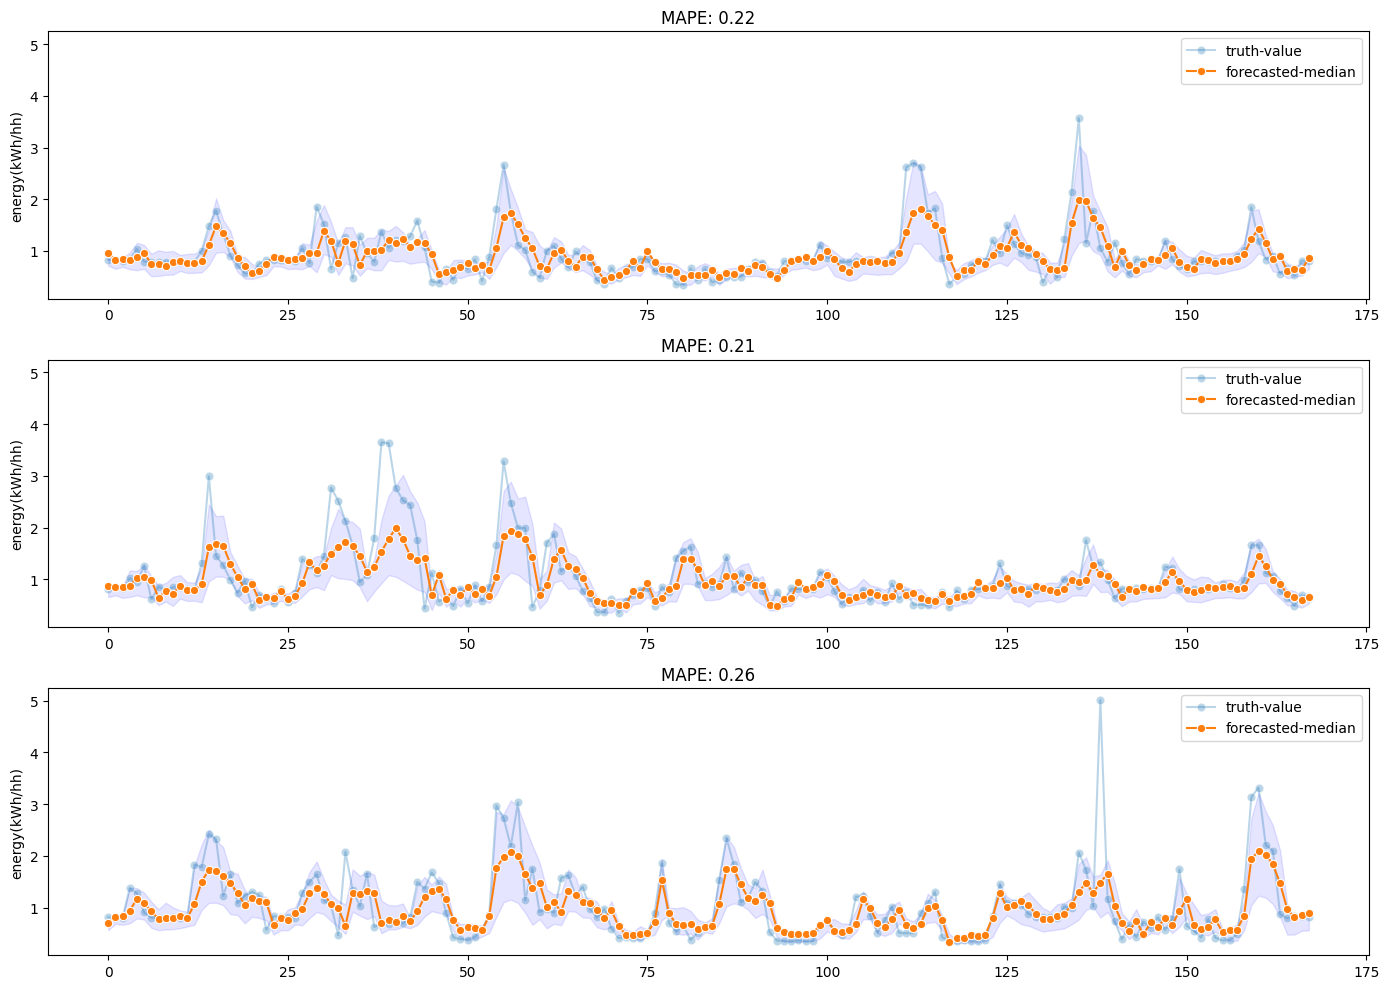

In [173]:
plot_forecast(df_pred, y_test, 3, 168, (3 * 168))

### Quantile-XGBoost 

In [174]:
from xgboost import XGBRegressor

models = {}
alphas = np.array([0.2, 0.5, 0.8])
df_pred = pd.DataFrame(y_test.copy(deep=True))

xgb = XGBRegressor(
  n_estimators=500, 
  learning_rate=0.01, 
  random_state=42, 
  objective='reg:quantileerror',
  quantile_alpha=alphas,
  n_jobs=5 # use multi-threaded
)

xgb.fit(X_train, y_train)

# make predictions and construct the dataframe
y_pred = xgb.predict(X_test)
df_pred = np.hstack([np.expand_dims(y_test, axis=1), y_pred])
df_pred = pd.DataFrame(df_pred, columns=['energy(kWh/hh)', 'pred_0.2', 'pred_0.5', 'pred_0.8'])
df_pred

energy(kWh/hh)  pred_0.2  pred_0.5  pred_0.8
0              0.751  0.611830  0.748574  0.823136
1              0.758  0.677526  0.776123  0.834740
2              0.750  0.617725  0.762751  0.848484
3              0.856  0.620731  0.767813  0.891534
4              0.886  0.662792  0.786951  0.935998
...              ...       ...       ...       ...
1192           1.130  0.820070  1.276632  1.451307
1193           1.128  0.840840  1.187251  1.355866
1194           1.123  0.824258  1.060789  1.328442
1195           1.375  0.736243  0.948138  1.187966
1196           0.435  0.760674  0.914516  1.032648

[1197 rows x 4 columns]

In [177]:
evaluate_model(df_pred, y_test)

RMSE: 0.3448124962444383
MSE: 0.1188956575663208
MAE: 0.209012448925774
MAPE: 0.2170259465491472
Pinball loss with alpha 0.2: 0.25984042217838055
Pinball loss with alpha 0.5: 0.104506224462887
Pinball loss with alpha 0.8: 0.1800884035510079
R2 Score: -0.1646394252998975
Adjusted R2 Score: -0.3054440043661457


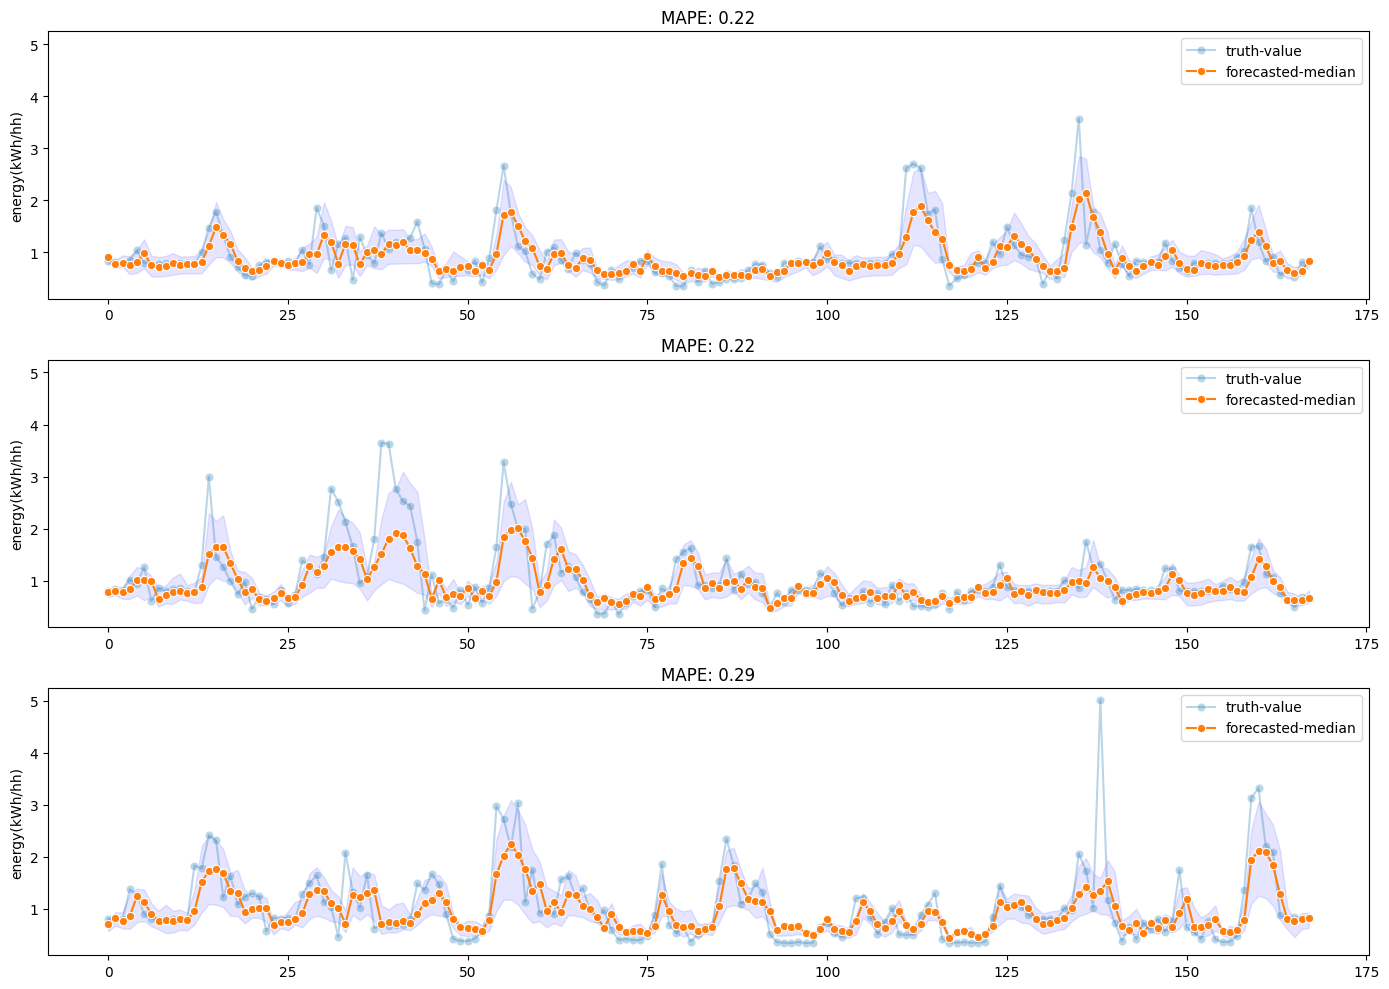

In [178]:
plot_forecast(df_pred, y_test, 3, 168, (3 * 168))

### Quantile LSTM

In [112]:
dl_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
dl_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print("DL Train Shape:", dl_train.shape)
print("DL Test Shape:", dl_test.shape)

DL Train Shape: (10770, 1, 129)
DL Test Shape: (1197, 1, 129)


In [110]:
import tensorflow as tf

def pinball_loss(y, y_hat, alpha):
  """
    Loss function for the deep learning models
  """

  error = (y - y_hat)
  loss = tf.keras.backend.mean(
    tf.keras.backend.maximum(alpha * error, (alpha - 1) * error), 
    axis=-1
  )

  return loss
  

In [180]:
from tensorflow.keras.layers import (
  Dense, LSTM, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_output_50_loss', patience=5)

### Create Model
input_layer = Input(shape=(1, dl_train.shape[2]))
layer = LSTM(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
  }
)

history = model.fit(
  dl_train,
  [y_train, y_train, y_train],
  epochs=50,
  validation_split=0.2,
  batch_size=32,
  callbacks=[earlystop]
)

Epoch 1/50
270/270 [==============================] - 4s 9ms/step - loss: 2.8048 - output_20_loss: 0.0722 - output_50_loss: 0.1440 - output_80_loss: 0.1511 - val_loss: 0.4536 - val_output_20_loss: 0.0851 - val_output_50_loss: 0.1555 - val_output_80_loss: 0.1384
Epoch 2/50
270/270 [==============================] - 2s 9ms/step - loss: 0.3458 - output_20_loss: 0.0640 - output_50_loss: 0.1160 - output_80_loss: 0.1075 - val_loss: 0.3968 - val_output_20_loss: 0.0810 - val_output_50_loss: 0.1387 - val_output_80_loss: 0.1264
Epoch 3/50
270/270 [==============================] - 3s 9ms/step - loss: 0.3137 - output_20_loss: 0.0607 - output_50_loss: 0.1063 - output_80_loss: 0.0968 - val_loss: 0.3899 - val_output_20_loss: 0.0799 - val_output_50_loss: 0.1369 - val_output_80_loss: 0.1254
Epoch 4/50
270/270 [==============================] - 2s 9ms/step - loss: 0.2966 - output_20_loss: 0.0591 - output_50_loss: 0.1011 - output_80_loss: 0.0911 - val_loss: 0.3532 - val_output_20_loss: 0.0745 - val_outp

In [181]:
model.evaluate(dl_test, [y_test, y_test, y_test])

38/38 [==============================] - 0s 8ms/step - loss: 0.1422 - output_20_loss: 0.0220 - output_50_loss: 0.0502 - output_80_loss: 0.0403


[0.14224275946617126,
 0.021963834762573242,
 0.0502435564994812,
 0.04033344238996506]

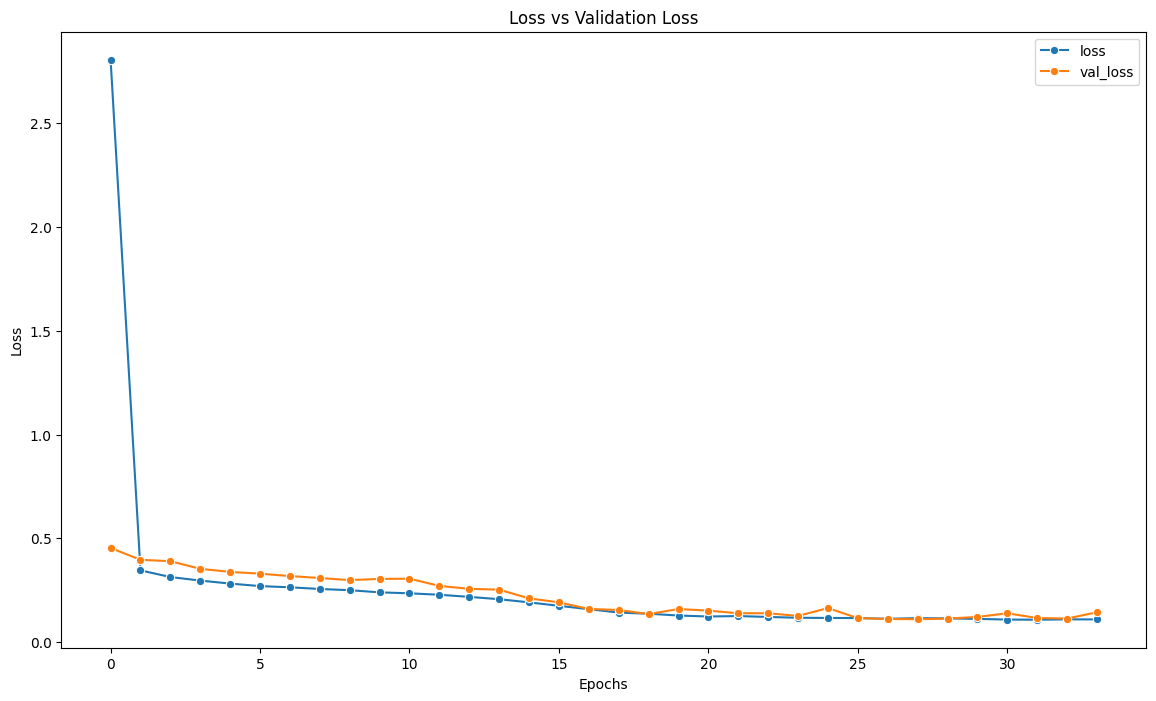

In [182]:
training_metrics = history.history
loss = training_metrics['loss']
val_loss = training_metrics['val_loss']


timesteps = np.arange(len(loss))
plt.figure(figsize=(14, 8))
sns.lineplot(x=timesteps, y=loss, label='loss', marker='o')
sns.lineplot(x=timesteps, y=val_loss, label='val_loss', marker='o')
plt.title("Loss vs Validation Loss")
plt.xlabel("Epochs")  
plt.ylabel("Loss")
plt.show()

In [185]:
y_pred = model.predict(dl_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional
y_pred = pd.DataFrame({
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
})


38/38 [==============================] - 1s 9ms/step


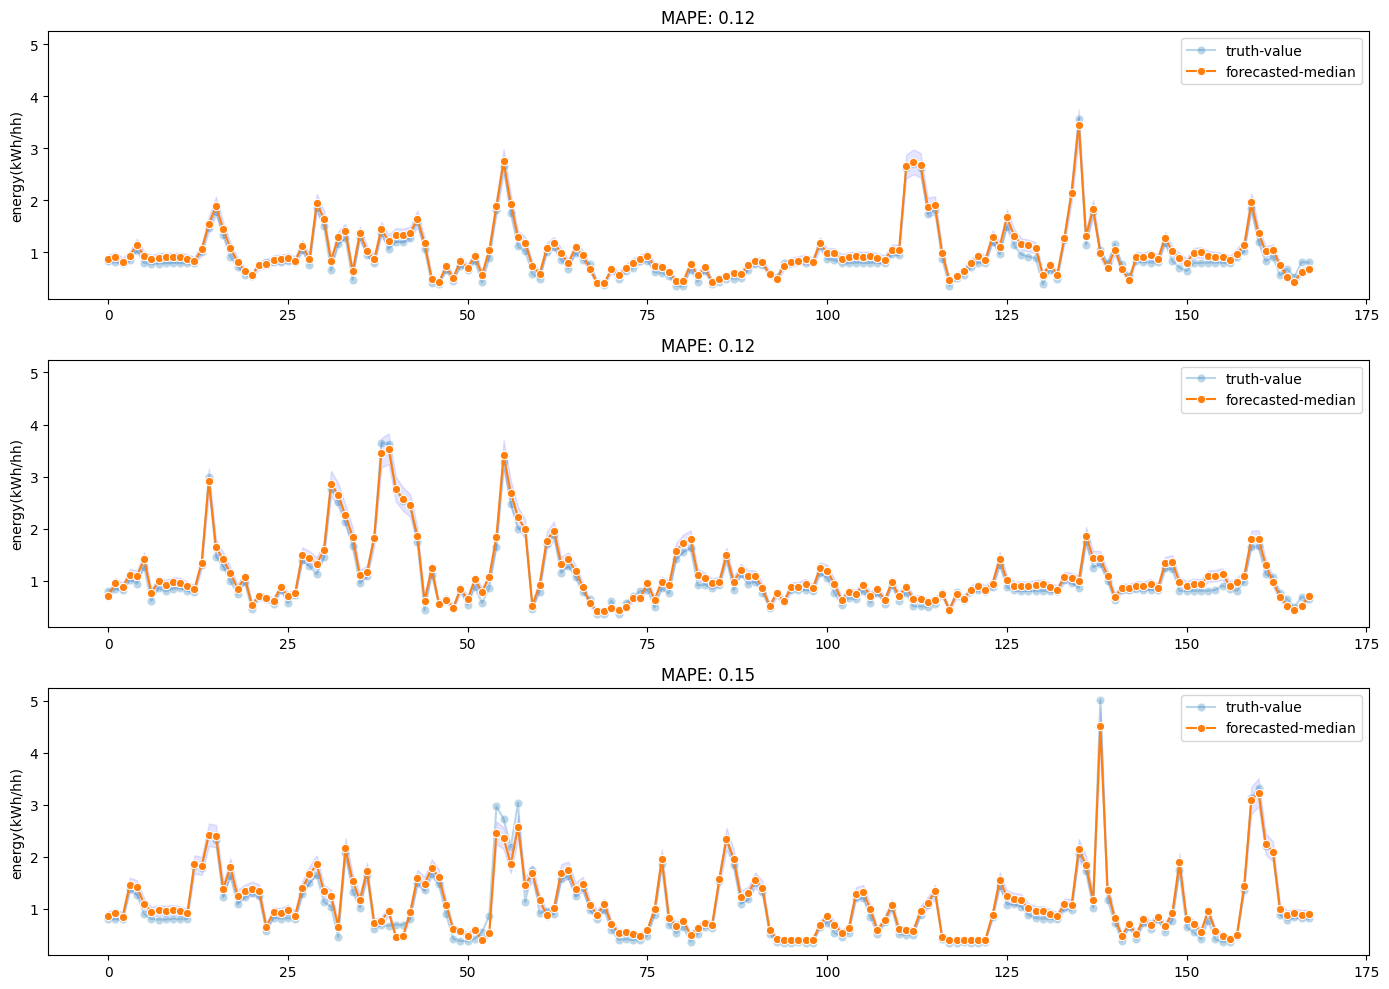

In [187]:
plot_forecast(y_pred, y_test, 3, 168, (3 * 168))

In [190]:
evaluate_model(y_pred, y_test)

RMSE: 0.11480587890545041
MSE: 0.013180389831252942
MAE: 0.10048711828383317
MAPE: 0.10935813867439302
Pinball loss with alpha 0.2: 0.03202701874958267
Pinball loss with alpha 0.5: 0.05024355914191658
Pinball loss with alpha 0.8: 0.15396550069250442
R2 Score: 0.9512231517364125
Adjusted R2 Score: 0.9453260444955476


### Quantile-GRU

In [191]:
from tensorflow.keras.layers import (
  Dense, GRU, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_output_50_loss', patience=5)

### Create Model
input_layer = Input(shape=(1, dl_train.shape[2]))
layer = GRU(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
  }
)

history = model.fit(
  dl_train,
  [y_train, y_train, y_train],
  epochs=50,
  validation_split=0.2,
  batch_size=32,
  callbacks=[earlystop]
)

Epoch 1/50
270/270 [==============================] - 4s 9ms/step - loss: 2.8257 - output_20_loss: 0.0715 - output_50_loss: 0.1402 - output_80_loss: 0.1453 - val_loss: 0.4495 - val_output_20_loss: 0.0829 - val_output_50_loss: 0.1511 - val_output_80_loss: 0.1367
Epoch 2/50
270/270 [==============================] - 2s 9ms/step - loss: 0.3394 - output_20_loss: 0.0629 - output_50_loss: 0.1122 - output_80_loss: 0.1038 - val_loss: 0.4008 - val_output_20_loss: 0.0811 - val_output_50_loss: 0.1387 - val_output_80_loss: 0.1253
Epoch 3/50
270/270 [==============================] - 2s 9ms/step - loss: 0.3076 - output_20_loss: 0.0596 - output_50_loss: 0.1034 - output_80_loss: 0.0932 - val_loss: 0.3878 - val_output_20_loss: 0.0794 - val_output_50_loss: 0.1375 - val_output_80_loss: 0.1238
Epoch 4/50
270/270 [==============================] - 2s 8ms/step - loss: 0.2929 - output_20_loss: 0.0580 - output_50_loss: 0.0987 - output_80_loss: 0.0884 - val_loss: 0.3593 - val_output_20_loss: 0.0750 - val_outp

In [163]:
model.evaluate(dl_test, [y_test, y_test, y_test])

38/38 [==============================] - 0s 6ms/step - loss: 0.1307 - output_20_loss: 0.0318 - output_50_loss: 0.0443 - output_80_loss: 0.0236


[0.13065485656261444,
 0.03177822381258011,
 0.044290315359830856,
 0.02357005886733532]

In [164]:
y_pred = model.predict(dl_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional
y_pred = pd.DataFrame({
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
})


38/38 [==============================] - 0s 4ms/step


In [167]:
evaluate_model(y_pred['pred_0.5'], y_test, deep_learning=True)

RMSE: 0.11252119526877147
MSE: 0.012661019384713
MAE: 0.0885806281323267
MAPE: 0.11490623654244661
Pinball loss with alpha 0.2: 0.06837644818361802
Pinball loss with alpha 0.5: 0.04429031406616335
Pinball loss with alpha 0.8: 0.020204179948708705
R2 Score: 0.9472257830747864
Adjusted R2 Score: 0.9408453950866398


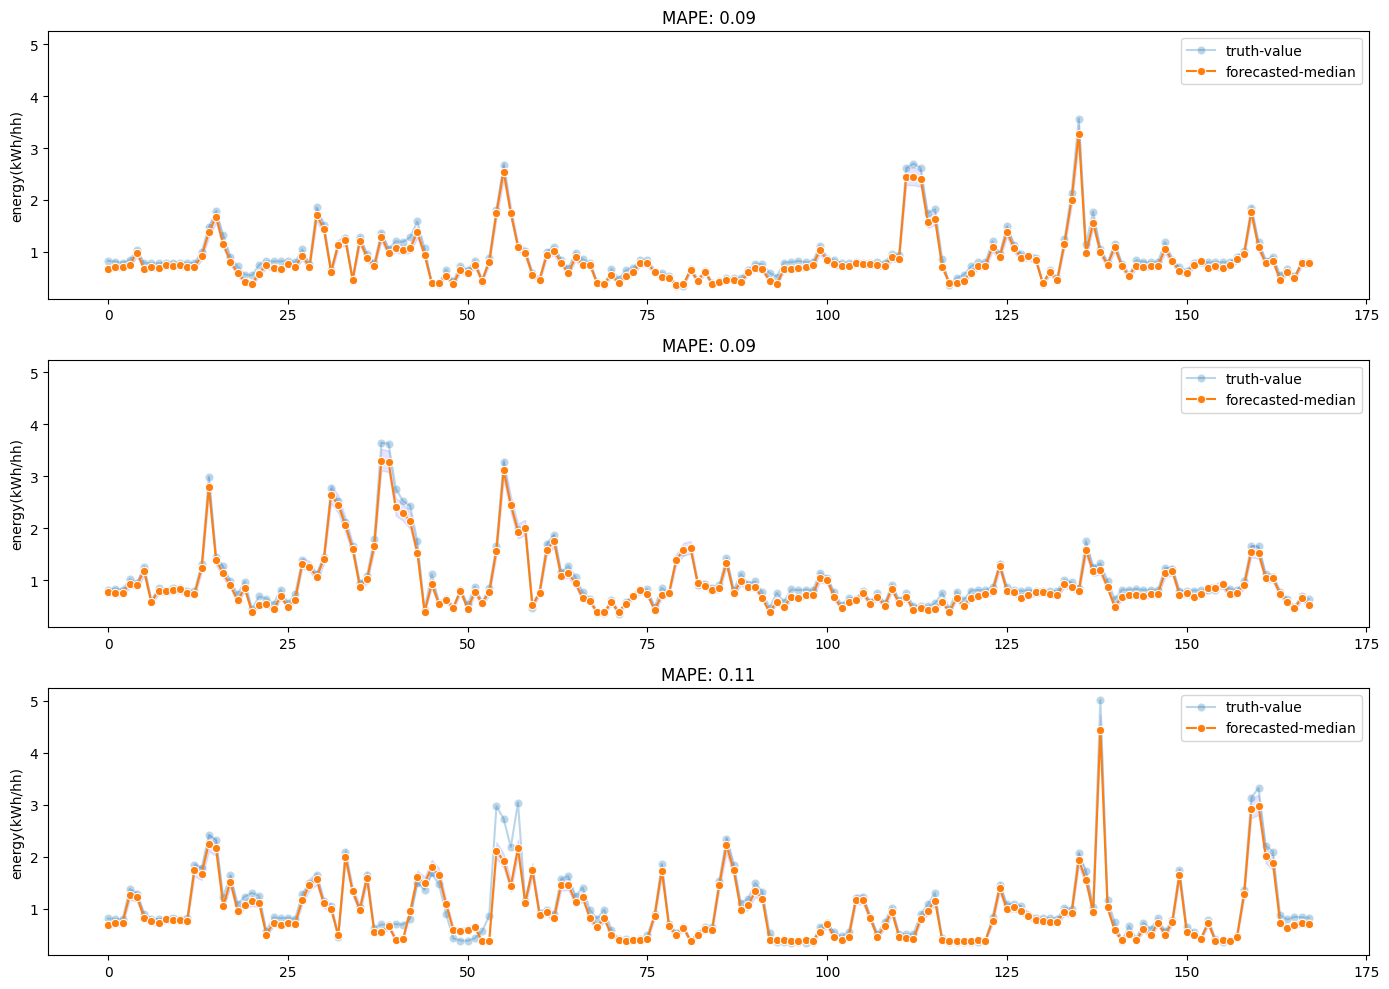

In [165]:
plot_forecast(y_pred, y_test, 3, 168, (3 * 168))

# Multiple Households

In [4]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

def create_fourier(date_index):
    fourier = CalendarFourier(
        freq='D',
        order=1
    )
    dp = DeterministicProcess(
        index=date_index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True
    )

    return dp

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# label encoding
precip_encoder = OneHotEncoder(sparse_output=False)
holiday_encoder = OneHotEncoder(sparse_output=False)
summary_encoder = OneHotEncoder(sparse_output=False)
household_encoder = LabelEncoder()
stdor_encoder = OneHotEncoder(sparse_output=False)
acorn_encoder = LabelEncoder()

precip_labels = precip_encoder.fit_transform(df[['precipType']])
holiday_labels = holiday_encoder.fit_transform(df[['Type']])
summary_labels = summary_encoder.fit_transform(df[['summary']])
household_labels = household_encoder.fit_transform(df[['LCLid']])
stdor_labels = stdor_encoder.fit_transform(df[['stdorToU']])
acorn_labels = acorn_encoder.fit_transform(df[['Acorn']])

precip_labels = pd.DataFrame(precip_labels, columns=precip_encoder.get_feature_names_out()).astype('int8')
holiday_labels = pd.DataFrame(holiday_labels, columns=holiday_encoder.get_feature_names_out()).astype('int8')
summary_labels = pd.DataFrame(summary_labels, columns=summary_encoder.get_feature_names_out()).astype('int8')
household_labels = pd.DataFrame(household_labels, columns=['household_label']).astype('int8')
stdor_labels = pd.DataFrame(stdor_labels, columns=stdor_encoder.get_feature_names_out()).astype('int8')
acorn_labels = pd.DataFrame(acorn_labels, columns=['acorn_label']).astype('int8')

encoded_df = pd.concat([df, precip_labels, holiday_labels, summary_labels, household_labels, stdor_labels, acorn_labels], axis=1)
encoded_df = encoded_df.drop(['precipType', 'Type', 'summary', 'LCLid', 'stdorToU', 'Acorn'], axis=1)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
# process fourier features for each group and saved each group's deterministic process
import math

dps = {}

all_household_ids = encoded_df['household_label'].unique()
households_grp = encoded_df.groupby('household_label')
training_df = []
testing_df = []

for household_id in all_household_ids:
    # get the household from the entire df
    print("Household id:", household_id)
    singlehousehold_df = households_grp.get_group(household_id).sort_values(by='tstp', ascending=True)

    # split into train, test
    cutoff_point = math.floor(singlehousehold_df.shape[0] * 0.9)
    training_singlehousehold_df = singlehousehold_df.iloc[:cutoff_point].reset_index()
    testing_singlehousehold_df = singlehousehold_df.iloc[cutoff_point:].reset_index()

    # create fourier features
    fourier_obj = create_fourier(training_singlehousehold_df.set_index('tstp').asfreq('h').index)
    fourier_train_features = fourier_obj.in_sample().reset_index().drop(['tstp'], axis=1)
    training_singlehousehold_df = pd.concat([training_singlehousehold_df, fourier_train_features], axis=1)
    fourier_test_features = fourier_obj.out_of_sample(testing_singlehousehold_df.shape[0]).reset_index().drop(['index'], axis=1)
    testing_singlehousehold_df = pd.concat([testing_singlehousehold_df.reset_index().drop(['index'], axis=1), fourier_test_features], axis=1)
    
    # save the dp object
    dps[household_id] = fourier_obj

    # append to the household_dfs list
    training_df.append(training_singlehousehold_df)
    testing_df.append(testing_singlehousehold_df)

training_df = pd.concat(training_df, axis=0)
testing_df = pd.concat(testing_df, axis=0)

Household id: 35
Household id: 30
Household id: 14
Household id: 46
Household id: 41
Household id: 24
Household id: 26
Household id: 37
Household id: 6
Household id: 45
Household id: 19
Household id: 3
Household id: 39
Household id: 32
Household id: 8
Household id: 22
Household id: 11
Household id: 38
Household id: 42
Household id: 10
Household id: 15
Household id: 16
Household id: 29
Household id: 36
Household id: 1
Household id: 23
Household id: 31
Household id: 28
Household id: 21
Household id: 7
Household id: 49
Household id: 17
Household id: 27
Household id: 0
Household id: 44
Household id: 5
Household id: 40
Household id: 12
Household id: 48
Household id: 33
Household id: 13
Household id: 2
Household id: 50
Household id: 43
Household id: 25
Household id: 34
Household id: 20
Household id: 18
Household id: 4
Household id: 9
Household id: 47


In [7]:
# scale the values
from sklearn.preprocessing import MinMaxScaler

# drop unnecessary columns
training_df = training_df.drop(['index', 'tstp'], axis=1)
testing_df = testing_df.drop(['level_0', 'tstp'], axis=1)

# separate into features and target
X_train = training_df.drop(['energy(kWh/hh)'], axis=1)
X_test = testing_df.drop(['energy(kWh/hh)'], axis=1)
y_train = training_df['energy(kWh/hh)']
y_test = testing_df['energy(kWh/hh)']

# store the household ids for future evaluation
test_household_ids = X_test['household_label']
train_household_ids = X_train['household_label']

# Scale with MinMax Normalization
scaler = MinMaxScaler(feature_range=(0, 1)) # scale to 0 and 1
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape for LSTM, CNN-LSTM models
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)
print(X_test.shape)

(686587, 1, 134)
(76315, 1, 134)


## Modelling

In [8]:
from sklearn.metrics import (
   mean_absolute_percentage_error, 
   mean_absolute_error, 
   mean_squared_error, 
   r2_score,
   mean_pinball_loss
)

def adjusted_r2(y_pred, y_test):
   p = X_train.shape[1]
   r2 = r2_score(y_pred, y_test)
   n = y_test.shape[0]
   
   adjusted_coefficient = 1 - (1 - r2) * (n - 1) / (n - p - 1)

   return adjusted_coefficient

def evaluate_model(y_pred, y_test):
  """
    Evaluate the model predictions with all the regression metrics
  """

  print("RMSE:", mean_squared_error(y_test, y_pred['pred_0.5'], squared=False))
  print("MSE:", mean_squared_error(y_test, y_pred['pred_0.5'], squared=True))
  print("MAE:", mean_absolute_error(y_test, y_pred['pred_0.5']))
  print("MAPE:", mean_absolute_percentage_error(y_test, y_pred['pred_0.5']))
  print("R2 Score:", r2_score(y_test, y_pred['pred_0.5']))
  print("Adjusted R2 Score:", adjusted_r2(y_test, y_pred['pred_0.5']))

  print("Pinball loss with alpha 0.1:", mean_pinball_loss(y_test, y_pred['pred_0.1'], alpha=0.1))
  print("Pinball loss with alpha 0.3:", mean_pinball_loss(y_test, y_pred['pred_0.3'], alpha=0.3))
  print("Pinball loss with alpha 0.5:", mean_pinball_loss(y_test, y_pred['pred_0.5'], alpha=0.5))
  print("Pinball loss with alpha 0.7:", mean_pinball_loss(y_test, y_pred['pred_0.7'], alpha=0.7))
  print("Pinball loss with alpha 0.9:", mean_pinball_loss(y_test, y_pred['pred_0.9'], alpha=0.9))

def plot_forecast(y_pred, y_test, number_of_slices=3, steps=168, skip=0):
    """
      Plot the forecasted values against the truth values for LSTM and CNN-LSTM
    """
    fig, axes = plt.subplots(number_of_slices, 1, sharey=True, figsize=(14, 10))
    timesteps = np.arange(0, steps)
    
    for i in range(number_of_slices):
        start_idx = 0 + (steps * i) + (skip)
        end_idx = steps * (1 + i) + (skip)
        sampled_test = y_test.iloc[start_idx:end_idx]
        sampled_pred = y_pred.iloc[start_idx:end_idx]
        mape_score = mean_absolute_percentage_error(sampled_test, sampled_pred['pred_0.5'])
        
        sns.lineplot(x=timesteps, y=sampled_test, label="truth-value", marker='o', alpha=0.3, ax=axes[i])
        sns.lineplot(x=timesteps, y=sampled_pred['pred_0.5'], label="forecasted-median", marker='o', ax=axes[i])
        axes[i].fill_between(x=timesteps, y1=sampled_pred['pred_0.1'], y2=sampled_pred['pred_0.9'], alpha=0.1, color='blue', label="10th-90th")
        axes[i].fill_between(x=timesteps, y1=sampled_pred['pred_0.3'], y2=sampled_pred['pred_0.7'], alpha=0.15, color='blue', label="30th-70th")
        axes[i].set_title(f'MAPE: {round(mape_score, 2)}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    

### Quantile-XGBoost

In [ ]:
# reshape back to the original shape for XGBoost
ml_train = X_train.reshape(X_train.shape[0], X_train.shape[2]) 
ml_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

from xgboost import XGBRegressor

alphas = np.array([0.1, 0.3, 0.5, 0.7, 0.9])

xgb = XGBRegressor(
  n_estimators=500, 
  learning_rate=0.01,
  max_depth=8, 
  random_state=42, 
  objective='reg:quantileerror',
  quantile_alpha=alphas,
  n_jobs=5 # use multi-threaded
)

# fit the model
xgb.fit(ml_train, y_train)

# make predictions and construct the dataframe
y_pred = xgb.predict(ml_test)
y_pred = pd.DataFrame(y_pred, columns=['pred_0.1', 'pred_0.3', 'pred_0.5', 'pred_0.7', 'pred_0.9'])
y_pred


In [ ]:
evaluate_model(y_pred, y_test)

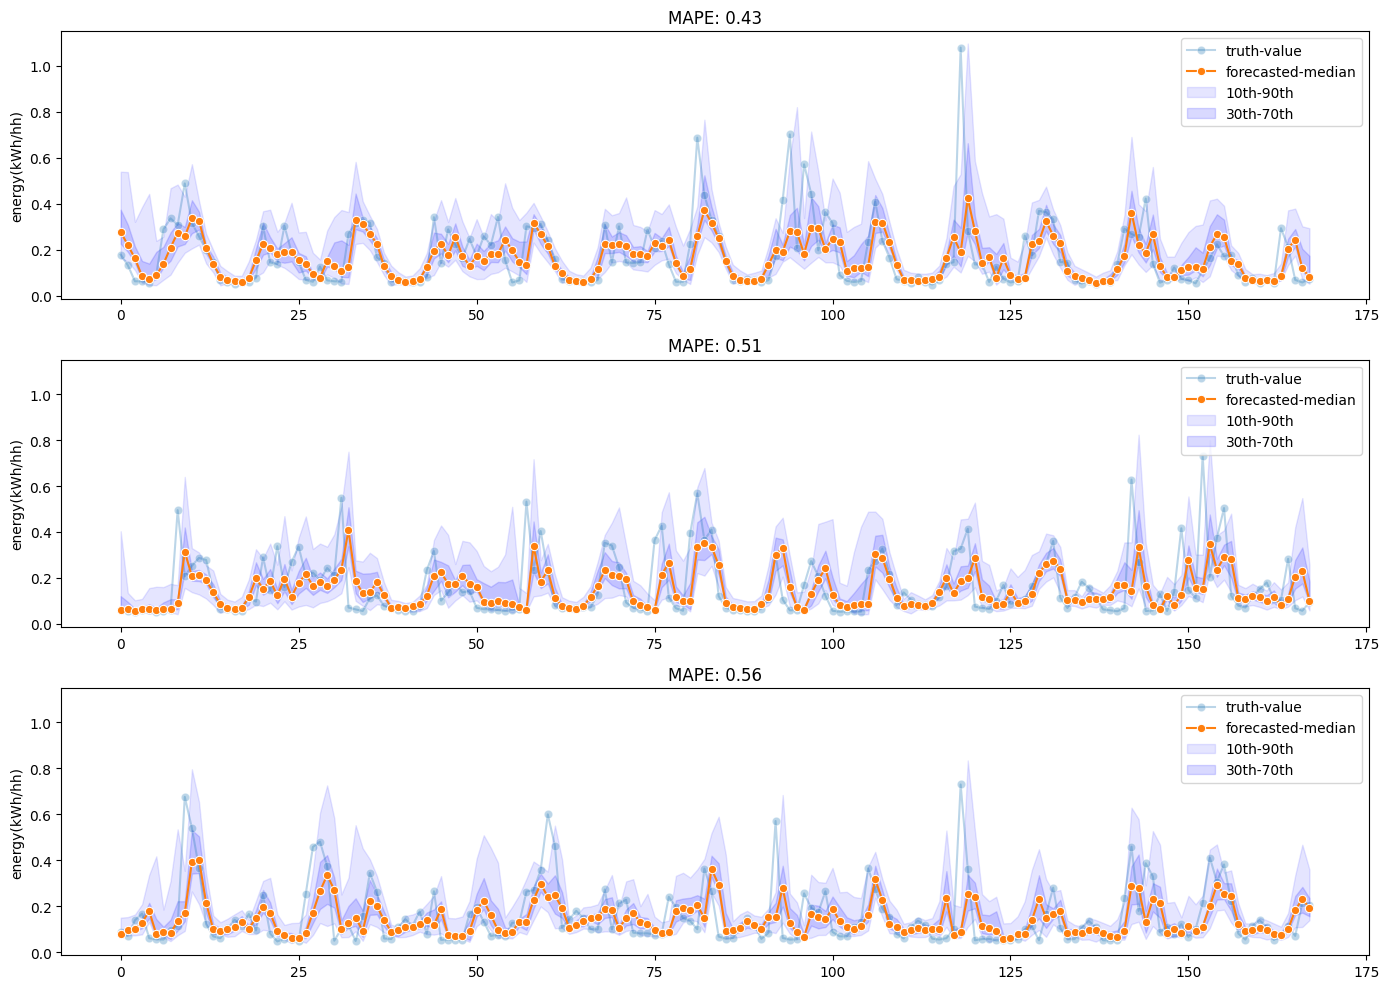

In [19]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

### Quantile-LightGBM

In [60]:
# Train with LightGBM

from lightgbm import LGBMRegressor

models = {}
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
y_pred = {}

for alpha in alphas:
  model = LGBMRegressor(
    n_estimators=500, 
    learning_rate=0.01, 
    max_depth=8,
    random_state=42, 
    objective='quantile', 
    alpha=alpha
  )
  model.fit(ml_train, y_train)
  y_pred[f'pred_{str(alpha)}'] = model.predict(ml_test)
  models[f'model_{str(alpha)}'] = model
  print(f"Model_{str(alpha)} trained successfully...")

y_pred = pd.DataFrame(y_pred)
y_pred

Model_0.1 trained successfully...
Model_0.3 trained successfully...
Model_0.5 trained successfully...
Model_0.7 trained successfully...
Model_0.9 trained successfully...


pred_0.1  pred_0.3  pred_0.5  pred_0.7  pred_0.9
0      0.478123  0.701353  0.778878  0.829215  0.826110
1      0.479048  0.688806  0.773612  0.827877  0.886978
2      0.481128  0.710996  0.821213  0.913359  1.116514
3      0.481128  0.696414  0.822179  1.007619  1.504327
4      0.522916  0.720635  0.877655  1.068380  1.552072
...         ...       ...       ...       ...       ...
76310  0.026569  0.044021  0.070118  0.100471  0.188821
76311  0.030121  0.048692  0.059922  0.078416  0.148788
76312  0.025840  0.043466  0.051934  0.060637  0.094706
76313  0.027599  0.028738  0.046930  0.060145  0.097978
76314  0.019407  0.082779  0.089023  0.092065  0.143622

[76315 rows x 5 columns]

In [61]:
evaluate_model(y_pred, y_test)

RMSE: 0.3972489305916468
MSE: 0.157806712856207
MAE: 0.17660913495710223
MAPE: 1587920025896.193
R2 Score: 0.6196445584086538
Adjusted R2 Score: 0.6196395742586193
Pinball loss with alpha 0.1: 0.03089080858418984
Pinball loss with alpha 0.3: 0.06866812074419552
Pinball loss with alpha 0.5: 0.08830456747855112
Pinball loss with alpha 0.7: 0.08969316244117728
Pinball loss with alpha 0.9: 0.05925279327405574


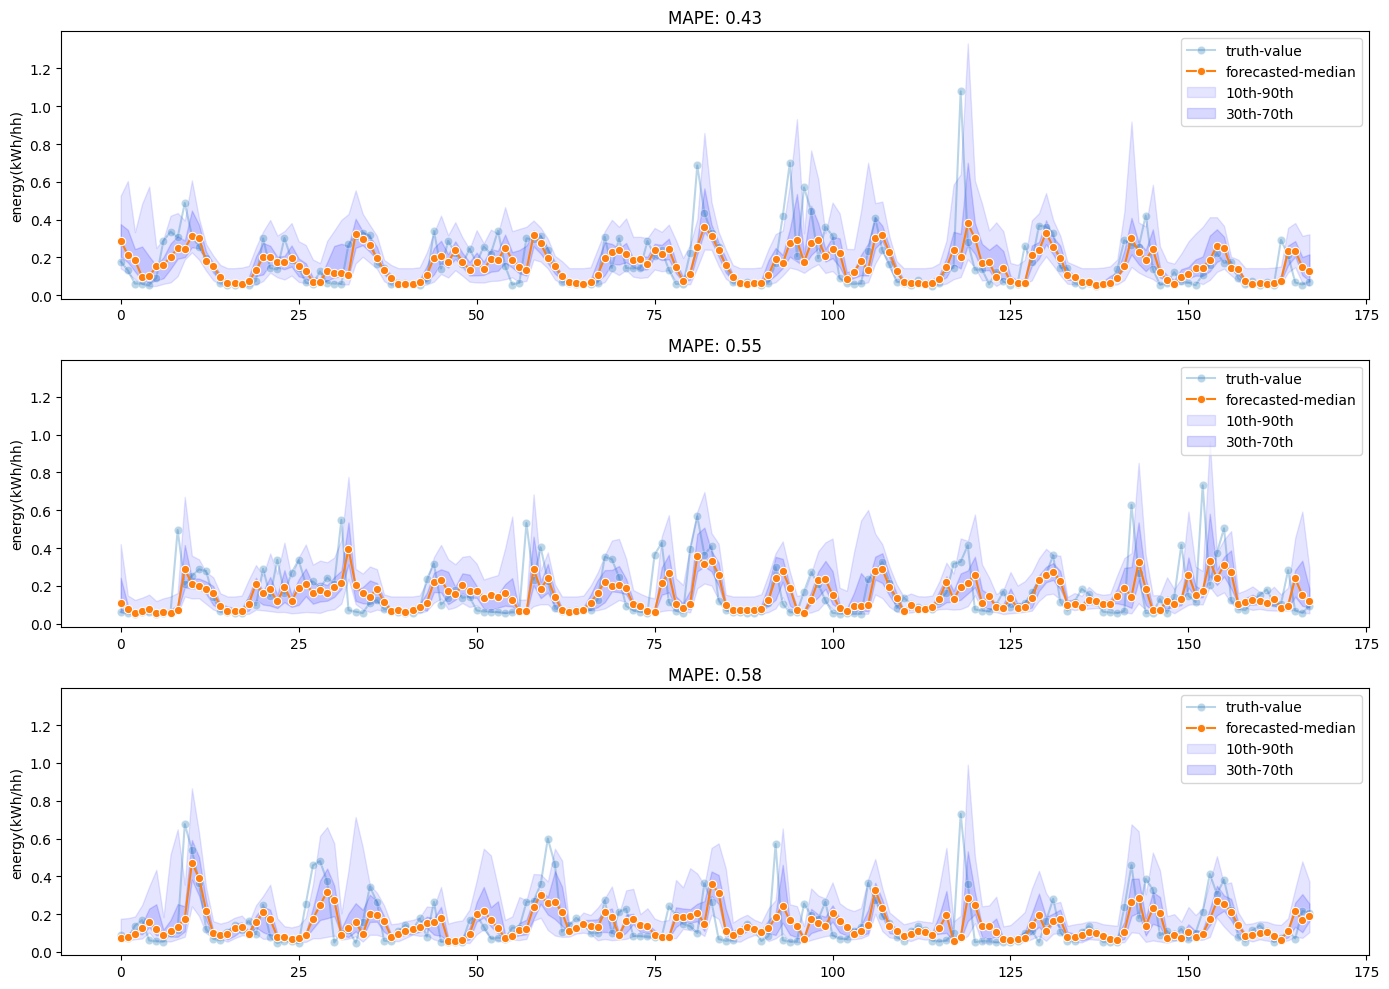

In [62]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

### Quantile-LSTM

In [10]:
import tensorflow as tf

def pinball_loss(y, y_hat, alpha):
  """
    Loss function for the deep learning models
  """

  error = (y - y_hat)
  loss = tf.keras.backend.mean(
    tf.keras.backend.maximum(alpha * error, (alpha - 1) * error), 
    axis=-1
  )

  return loss

def plot_training_metrics(history):
  """
    Function to plot the training metrics of the deep learning models
  """
  training_metrics = history.history
  loss = training_metrics['loss']
  val_loss = training_metrics['val_loss']
  loss_10 = training_metrics['output_10_loss']
  val_loss_10 = training_metrics['val_output_10_loss']
  loss_30 = training_metrics['output_30_loss']
  val_loss_30 = training_metrics['val_output_30_loss']
  loss_50 = training_metrics['output_50_loss']
  val_loss_50 = training_metrics['val_output_50_loss']
  loss_70 = training_metrics['output_70_loss']
  val_loss_70 = training_metrics['val_output_70_loss']
  loss_90 = training_metrics['output_90_loss']
  val_loss_90 = training_metrics['val_output_90_loss']


  timesteps = np.arange(len(loss))
  fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20, 12))

  sns.lineplot(x=timesteps, y=loss, label='loss', marker='o', ax=axes[0][0])
  sns.lineplot(x=timesteps, y=val_loss, label='val_loss', marker='o', ax=axes[0][0])
  axes[0][0].set_title("Loss vs Validation Loss")
  axes[0][0].set_xlabel("Epochs")  
  axes[0][0].set_ylabel("Overall Loss")

  sns.lineplot(x=timesteps, y=loss_10, label='loss_10', marker='o', ax=axes[0][1])
  sns.lineplot(x=timesteps, y=val_loss_10, label='val_loss_10', marker='o', ax=axes[0][1])
  axes[0][1].set_title("Loss vs Validation Loss; alpha=0.1")
  axes[0][1].set_xlabel("Epochs")  
  axes[0][1].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_30, label='loss_30', marker='o', ax=axes[0][2])
  sns.lineplot(x=timesteps, y=val_loss_30, label='val_loss_30', marker='o', ax=axes[0][2])
  axes[0][2].set_title("Loss vs Validation Loss; alpha=0.3")
  axes[0][2].set_xlabel("Epochs")  
  axes[0][2].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_50, label='loss_50', marker='o', ax=axes[1][0])
  sns.lineplot(x=timesteps, y=val_loss_50, label='val_loss_50', marker='o', ax=axes[1][0])
  axes[1][0].set_title("Loss vs Validation Loss; alpha=0.5")
  axes[1][0].set_xlabel("Epochs")  
  axes[1][0].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_70, label='loss_70', marker='o', ax=axes[1][1])
  sns.lineplot(x=timesteps, y=val_loss_70, label='val_loss_70', marker='o', ax=axes[1][1])
  axes[1][1].set_title("Loss vs Validation Loss; alpha=0.7")
  axes[1][1].set_xlabel("Epochs")  
  axes[1][1].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_90, label='loss_90', marker='o', ax=axes[1][2])
  sns.lineplot(x=timesteps, y=val_loss_90, label='val_loss_90', marker='o', ax=axes[1][2])
  axes[1][2].set_title("Loss vs Validation Loss; alpha=0.9")
  axes[1][2].set_xlabel("Epochs")  
  axes[1][2].set_ylabel("Pinball Loss")

  plt.tight_layout()
  plt.show()
  

In [14]:
from tensorflow.keras.layers import (
  Dense, LSTM, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Create Model
input_layer = Input(shape=(1, X_train.shape[2]))
layer = LSTM(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_10 = TimeDistributed(Dense(1), name="output_10")(layer)
output_layer_30 = TimeDistributed(Dense(1), name="output_30")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_70 = TimeDistributed(Dense(1), name="output_70")(layer)
output_layer_90 = TimeDistributed(Dense(1), name="output_90")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_10, output_layer_30, output_layer_50, output_layer_70, output_layer_90])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_10": lambda y, y_hat: pinball_loss(y, y_hat, 0.1),
    "output_30": lambda y, y_hat: pinball_loss(y, y_hat, 0.3),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_70": lambda y, y_hat: pinball_loss(y, y_hat, 0.7),
    "output_90": lambda y, y_hat: pinball_loss(y, y_hat, 0.9)
  }
)

history = model.fit(
  X_train,
  [y_train, y_train, y_train, y_train, y_train],
  epochs=50,
  validation_split=0.2,
  batch_size=168,
  callbacks=[earlystop]
)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/50
3270/3270 [==============================] - 35s 10ms/step - loss: 0.6222 - output_10_loss: 0.0340 - output_30_loss: 0.0778 - output_50_loss: 0.1009 - output_70_loss: 0.1035 - output_90_loss: 0.0723 - val_loss: 0.3066 - val_output_10_loss: 0.0264 - val_output_30_loss: 0.0560 - val_output_50_loss: 0.0699 - val_output_70_loss: 0.0716 - val_output_90_loss: 0.0519
Epoch 2/50
3270/3270 [==============================] - 36s 11ms/step - loss: 0.3840 - output_10_loss: 0.0323 - output_30_loss: 0.0722 - output_50_loss: 0.0923 - output_70_loss: 0.0937 - output_90_loss: 0.0651 - val_loss: 0.3083 - val_output_10_loss: 0.0272 - val_output_30_loss: 0.0574 - val_output_50_loss: 0.0712 - val_output_70_loss: 0.0728 - val_output_90_loss: 0.0523
Epoch 3/50
3270/3270 [==============================] - 36s 11ms/step - loss: 0.3777 - output_10_loss: 0.0317 - output_30_loss: 0.0711 - output_50_loss: 0.0912 - output_70_loss: 0.0927 - output_90_loss: 0.0641 - val_loss: 0.3084 - val_output_10_loss: 0

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1, 134)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 1, 100)       94000       ['input_3[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 1, 100)       0           ['lstm_2[0][0]']                 
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 1, 168)      16968       ['dropout_2[0][0]']              
 buted)                                                                                     

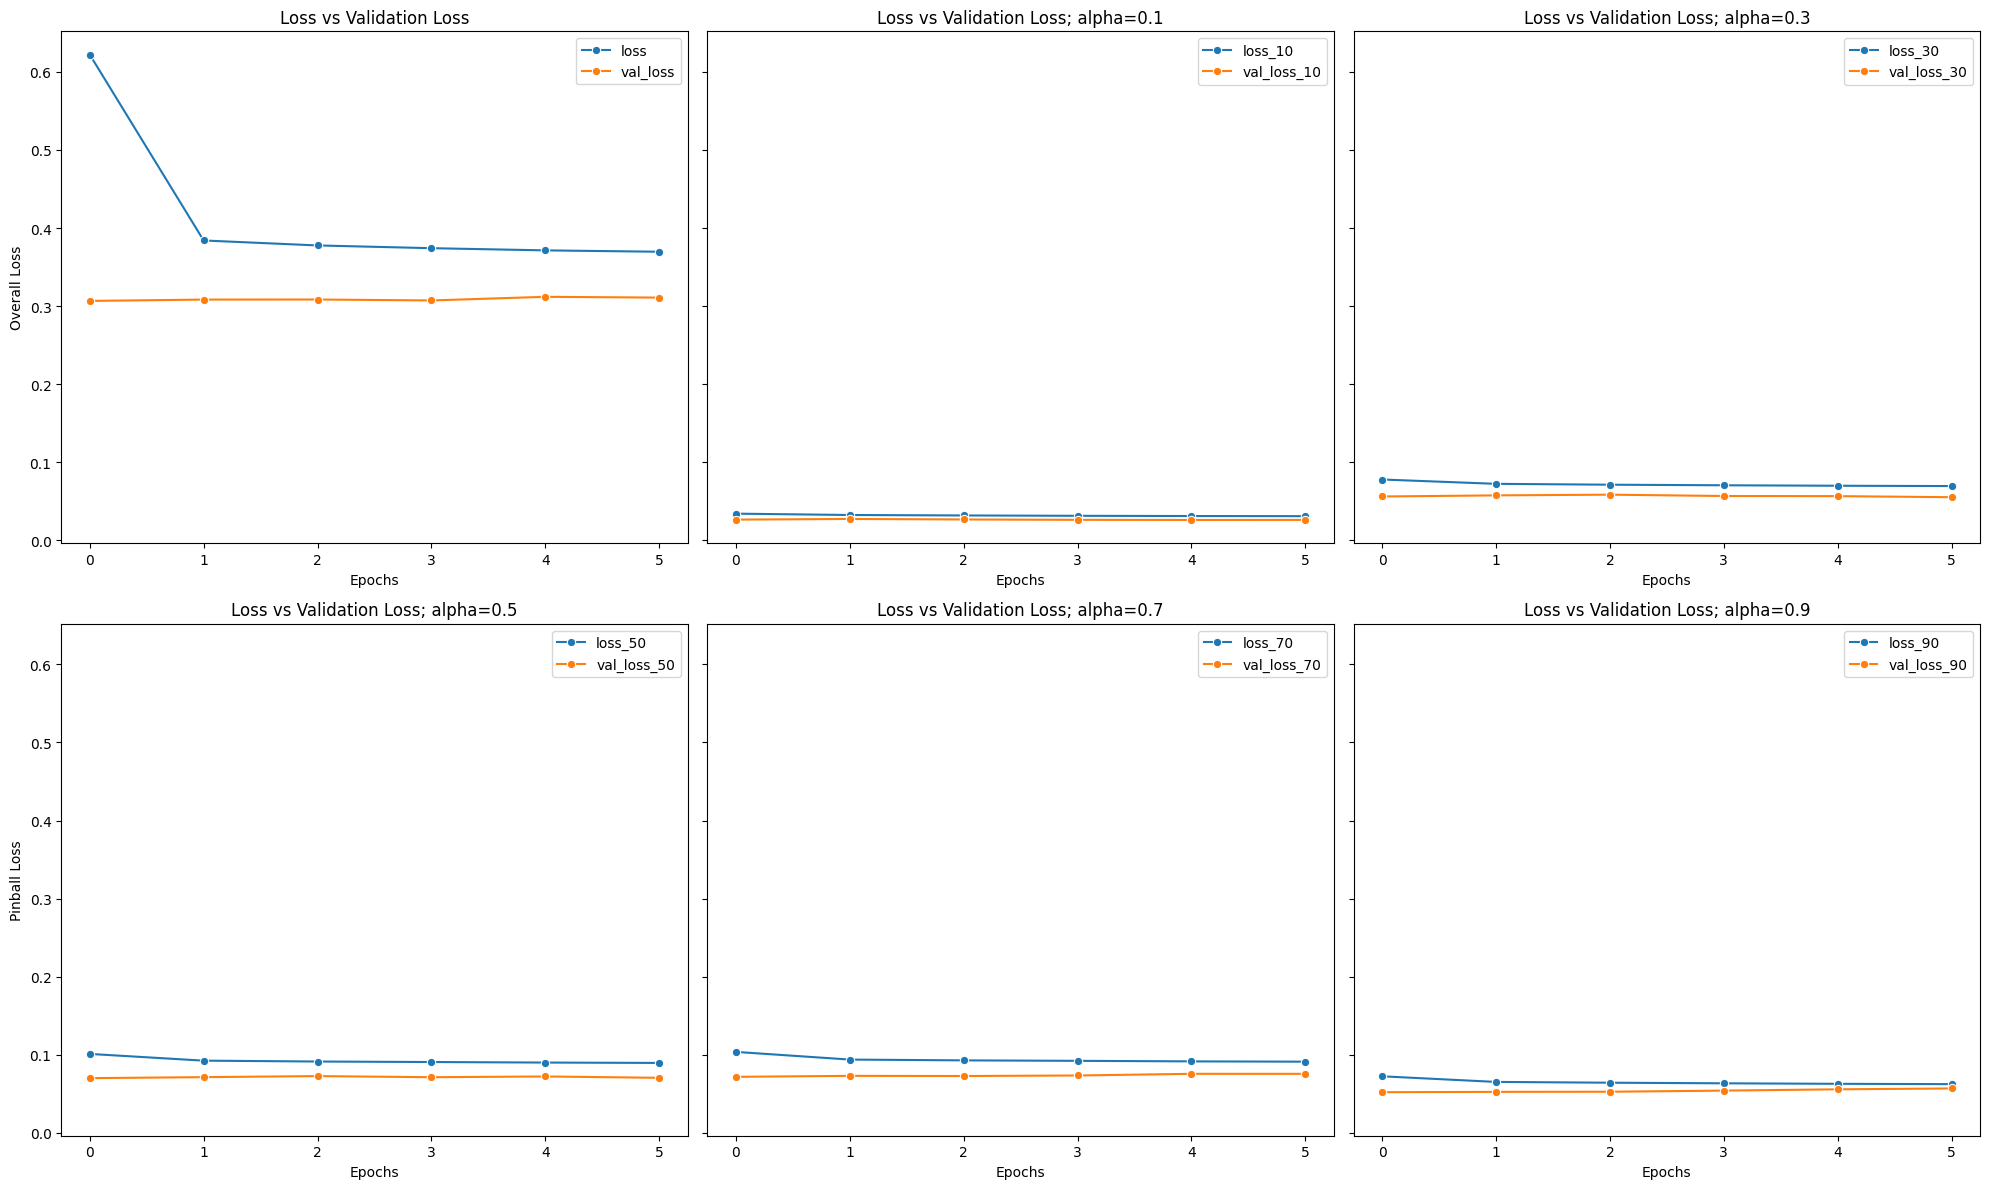

In [15]:
plot_training_metrics(history)

In [16]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.1': y_pred[0].ravel(),
  'pred_0.3': y_pred[1].ravel(),
  'pred_0.5': y_pred[2].ravel(),
  'pred_0.7': y_pred[3].ravel(),
  'pred_0.9': y_pred[4].ravel()
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 5s 2ms/step
RMSE: 0.39650291221461414
MSE: 0.15721455939467002
MAE: 0.1949529945149388
MAPE: 1804065727659.8787
R2 Score: 0.621071803088403
Adjusted R2 Score: 0.6210668376408789
Pinball loss with alpha 0.1: 0.03606178469872613
Pinball loss with alpha 0.3: 0.07788513662207519
Pinball loss with alpha 0.5: 0.0974764972574694
Pinball loss with alpha 0.7: 0.09813885848477231
Pinball loss with alpha 0.9: 0.06848551542090156


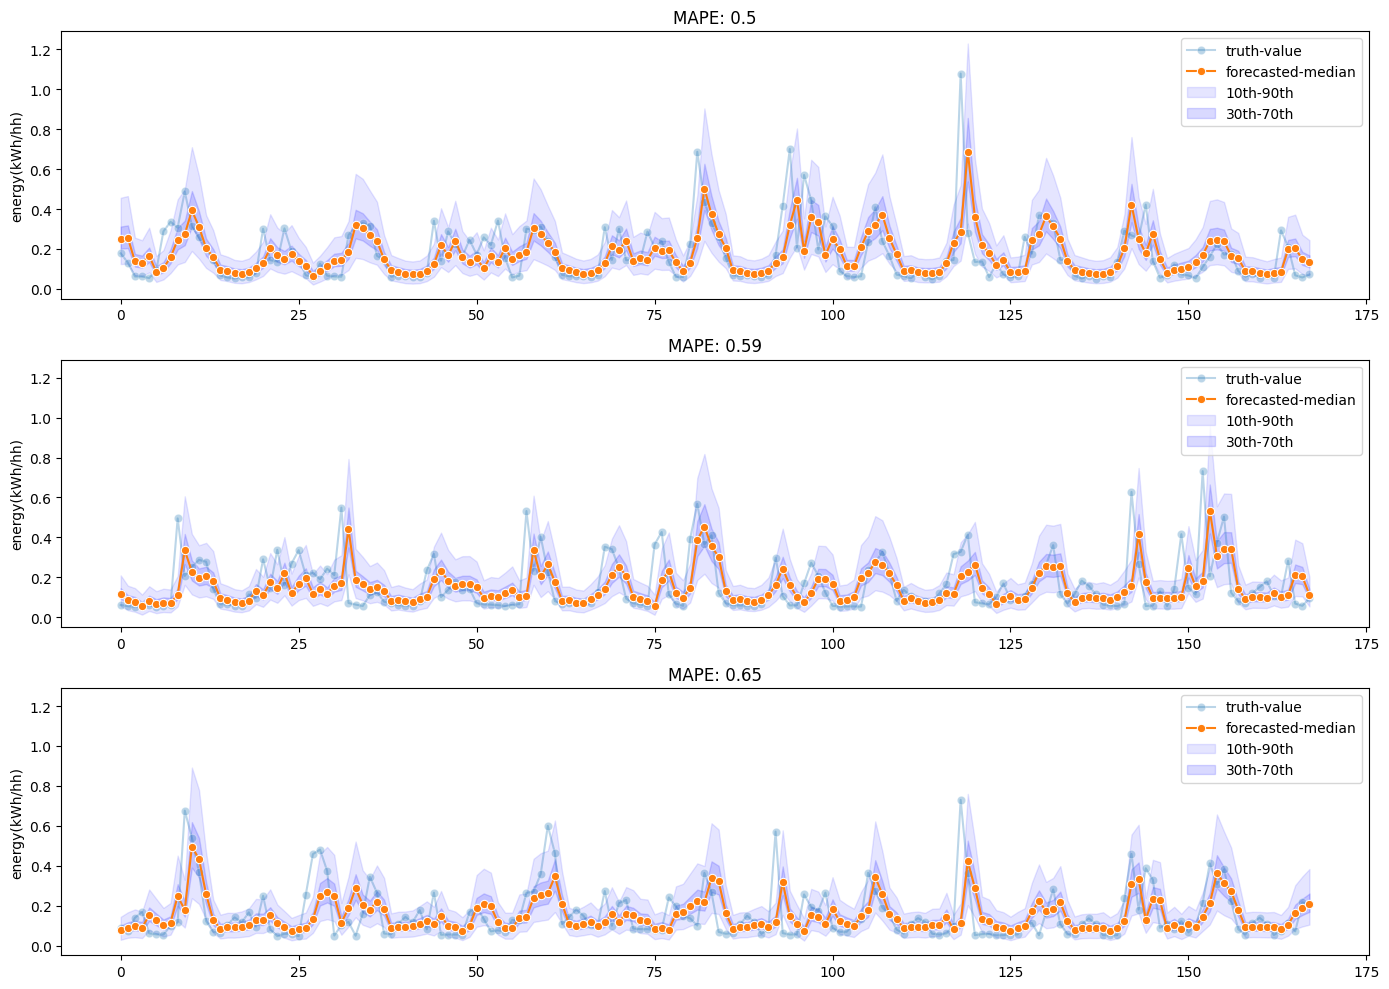

In [41]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

### Quantile-GRU

In [17]:
from tensorflow.keras.layers import (
  Dense, GRU, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Create Model
input_layer = Input(shape=(1, X_train.shape[2]))
layer = GRU(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_10 = TimeDistributed(Dense(1), name="output_10")(layer)
output_layer_30 = TimeDistributed(Dense(1), name="output_30")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_70 = TimeDistributed(Dense(1), name="output_70")(layer)
output_layer_90 = TimeDistributed(Dense(1), name="output_90")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_10, output_layer_30, output_layer_50, output_layer_70, output_layer_90])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_10": lambda y, y_hat: pinball_loss(y, y_hat, 0.1),
    "output_30": lambda y, y_hat: pinball_loss(y, y_hat, 0.3),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_70": lambda y, y_hat: pinball_loss(y, y_hat, 0.7),
    "output_90": lambda y, y_hat: pinball_loss(y, y_hat, 0.9)
  }
)

history = model.fit(
  X_train,
  [y_train, y_train, y_train, y_train, y_train],
  epochs=50,
  validation_split=0.2,
  batch_size=168,
  callbacks=[earlystop]
)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/50
3270/3270 [==============================] - 38s 11ms/step - loss: 0.6236 - output_10_loss: 0.0340 - output_30_loss: 0.0776 - output_50_loss: 0.1007 - output_70_loss: 0.1032 - output_90_loss: 0.0721 - val_loss: 0.3052 - val_output_10_loss: 0.0263 - val_output_30_loss: 0.0559 - val_output_50_loss: 0.0700 - val_output_70_loss: 0.0711 - val_output_90_loss: 0.0516
Epoch 2/50
3270/3270 [==============================] - 37s 11ms/step - loss: 0.3832 - output_10_loss: 0.0322 - output_30_loss: 0.0722 - output_50_loss: 0.0923 - output_70_loss: 0.0936 - output_90_loss: 0.0648 - val_loss: 0.3025 - val_output_10_loss: 0.0267 - val_output_30_loss: 0.0565 - val_output_50_loss: 0.0701 - val_output_70_loss: 0.0708 - val_output_90_loss: 0.0514
Epoch 3/50
3270/3270 [==============================] - 36s 11ms/step - loss: 0.3766 - output_10_loss: 0.0316 - output_30_loss: 0.0711 - output_50_loss: 0.0911 - output_70_loss: 0.0924 - output_90_loss: 0.0637 - val_loss: 0.3116 - val_output_10_loss: 0

In [46]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1, 134)]     0           []                               
                                                                                                  
 gru_3 (GRU)                    (None, 1, 100)       70800       ['input_7[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1, 100)       0           ['gru_3[0][0]']                  
                                                                                                  
 time_distributed_12 (TimeDistr  (None, 1, 168)      16968       ['dropout_6[0][0]']              
 ibuted)                                                                                    

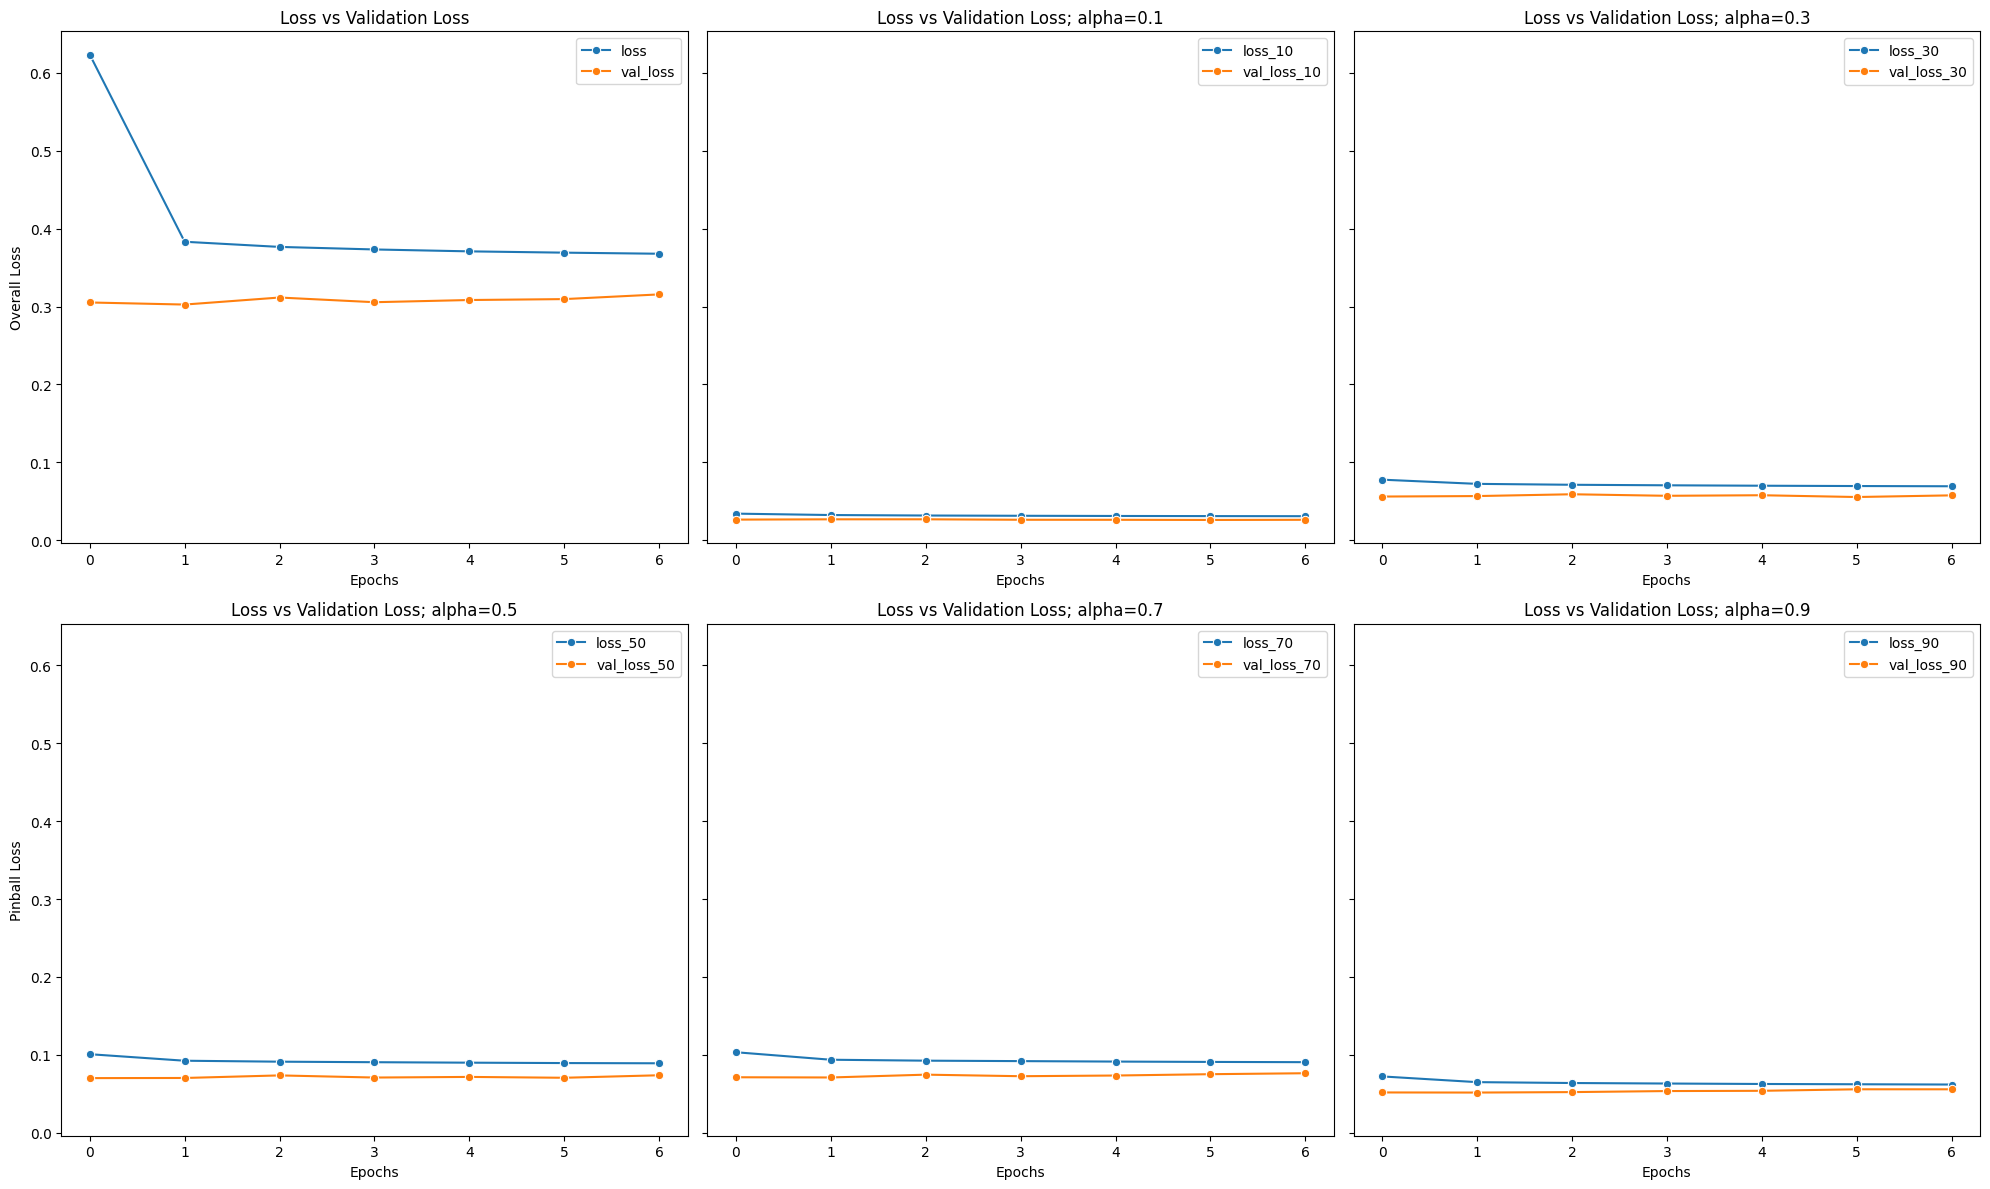

In [47]:
plot_training_metrics(history)

In [18]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.1': y_pred[0].ravel(),
  'pred_0.3': y_pred[1].ravel(),
  'pred_0.5': y_pred[2].ravel(),
  'pred_0.7': y_pred[3].ravel(),
  'pred_0.9': y_pred[4].ravel(),
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 4s 2ms/step
RMSE: 0.4073089217164609
MSE: 0.16590055770982606
MAE: 0.19517499348683626
MAPE: 2474395526364.843
R2 Score: 0.6001362759170511
Adjusted R2 Score: 0.600131036131902
Pinball loss with alpha 0.1: 0.03587336903896795
Pinball loss with alpha 0.3: 0.0780088611801516
Pinball loss with alpha 0.5: 0.09758749674341813
Pinball loss with alpha 0.7: 0.09641773462446672
Pinball loss with alpha 0.9: 0.06635581598955143


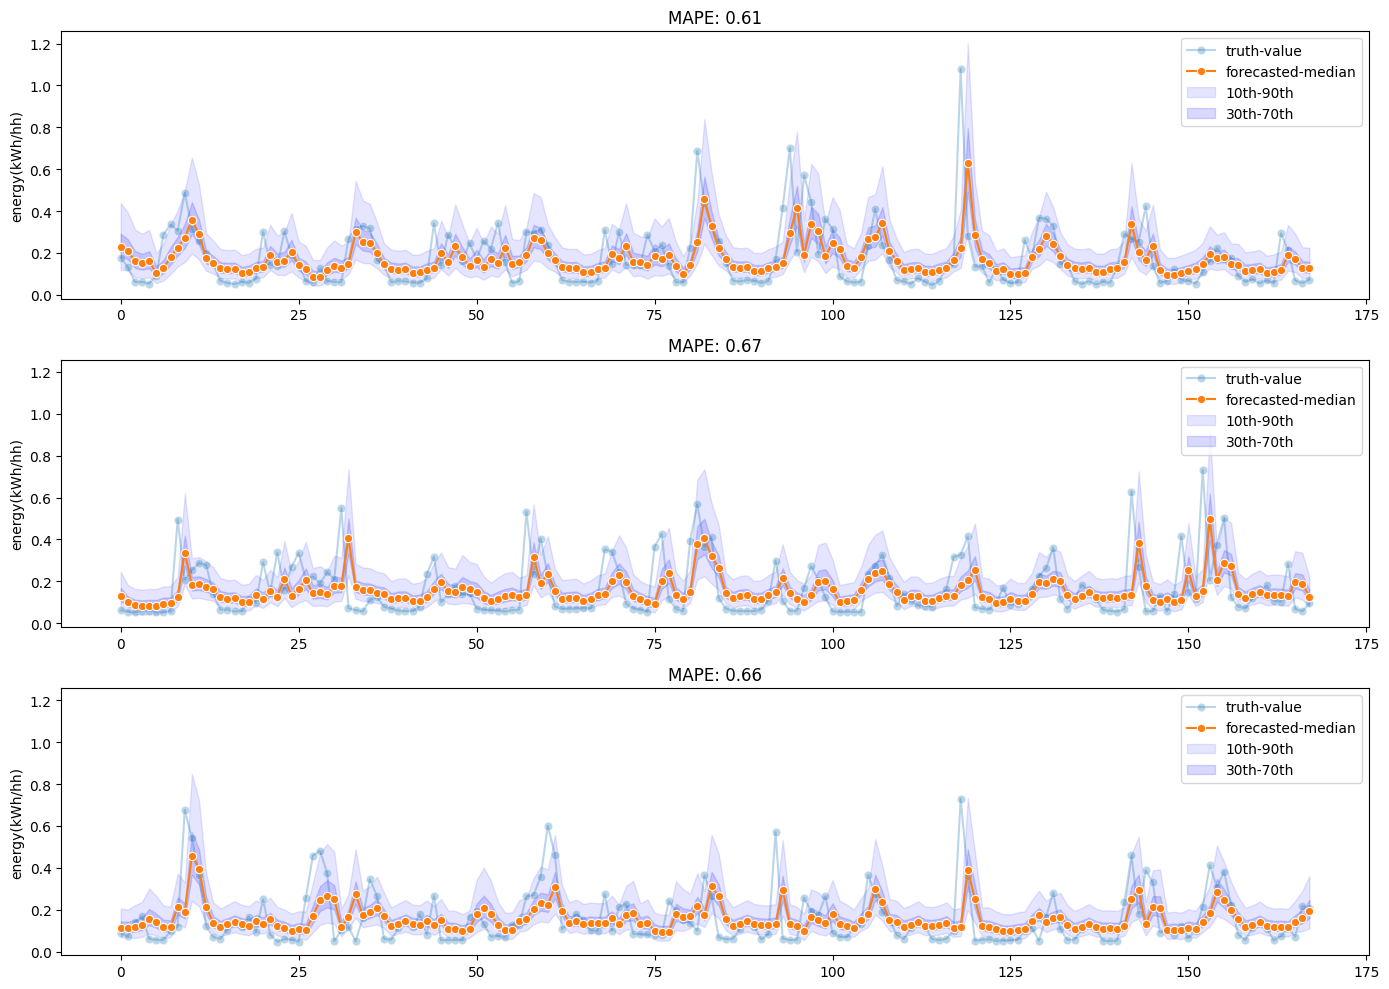

In [49]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

# Hyperparameter Tuning

### Quantile-XGBoost

In [25]:
from sklearn.model_selection import ParameterGrid, KFold
from xgboost import XGBRegressor
from sklearn.metrics import (
  mean_absolute_percentage_error, 
  mean_absolute_error, 
  mean_squared_error, 
  r2_score,
  mean_pinball_loss
)

# reshape back to the original shape for XGBoost
ml_train = X_train.reshape(X_train.shape[0], X_train.shape[2]) 
ml_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

# combine both ml dataset to form a whole dataset, then the KFold will handle the splitting of training/testing
combined_X = np.vstack((ml_train, ml_test))
combined_y = pd.concat([y_train, y_test], axis=0).values # y_train, y_test is pandas object so using pd.concat()

param_grid = {
  'max_depth': [8, 9],
  'n_estimators': [500, 750, 1000],
  'learning_rate': [0.01, 0.001, 0.03, 0.003],
  'reg_alpha': [0.5, 0.7]
}
param_grid = ParameterGrid(param_grid)
fold_generator = KFold(n_splits=3, shuffle=True, random_state=42)
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]

grid_results = { 'folds': [], 'params_used': [], 'pinball_loss_10': [], 'pinball_loss_30': [], 'pinball_loss_50': [], 'pinball_loss_70': [], 'pinball_loss_90': [], 'mape': [], 'mse': [], 'mae': [], 'rmse': [], 'r2': [], 'adjusted_r2': [] }

model_count = 0 # diff # of hyperparams set
for hyperparameters in param_grid:
  for i, (train_idx, test_idx) in enumerate(fold_generator.split(combined_X)):
    
    print(f"Training for model {model_count} on fold {i}... Hyperparameter: {hyperparameters}")
    xgb_model = XGBRegressor(objective='reg:quantileerror', random_state=42, n_jobs=5, quantile_alpha=alphas, **hyperparameters) # uses 5 CPU cores
    xgb_model.fit(combined_X[train_idx], combined_y[train_idx]) # train on different folds

    # make predictions and construct the dataframe
    y_pred = xgb_model.predict(combined_X[test_idx])
    y_pred = pd.DataFrame(y_pred, columns=['pred_0.1', 'pred_0.3', 'pred_0.5', 'pred_0.7', 'pred_0.9'])
    
    # point metrics
    mape = mean_absolute_percentage_error(combined_y[test_idx], y_pred['pred_0.5'])
    mae = mean_absolute_error(combined_y[test_idx], y_pred['pred_0.5'])
    mse = mean_squared_error(combined_y[test_idx], y_pred['pred_0.5'])
    rmse = mean_squared_error(combined_y[test_idx], y_pred['pred_0.5'], squared=False)
    r2 = r2_score(combined_y[test_idx], y_pred['pred_0.5'])
    adj_r2 = adjusted_r2(combined_y[test_idx], y_pred['pred_0.5'])

    # quantile loss
    loss_10 = mean_pinball_loss(combined_y[test_idx], y_pred['pred_0.1'], alpha=0.1)
    loss_30 = mean_pinball_loss(combined_y[test_idx], y_pred['pred_0.3'], alpha=0.3)
    loss_50 = mean_pinball_loss(combined_y[test_idx], y_pred['pred_0.5'], alpha=0.5)
    loss_70 = mean_pinball_loss(combined_y[test_idx], y_pred['pred_0.7'], alpha=0.7)
    loss_90 = mean_pinball_loss(combined_y[test_idx], y_pred['pred_0.9'], alpha=0.9)

    # store the results
    grid_results['folds'].append(i)
    grid_results['params_used'].append(hyperparameters)
    grid_results['mape'].append(mape)
    grid_results['mse'].append(mse)
    grid_results['rmse'].append(rmse)
    grid_results['mae'].append(mae)
    grid_results['r2'].append(r2)
    grid_results['adjusted_r2'].append(adj_r2)
    grid_results['pinball_loss_10'].append(loss_10)
    grid_results['pinball_loss_30'].append(loss_30)
    grid_results['pinball_loss_50'].append(loss_50)
    grid_results['pinball_loss_70'].append(loss_70)
    grid_results['pinball_loss_90'].append(loss_90)

  # for progress
  model_count += 1
  print(f"Training completed for Model {model_count}...")

grid_results = pd.DataFrame(grid_results)
grid_results

Training for model 0 on fold 0... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.5}
Training for model 0 on fold 1... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.5}
Training for model 0 on fold 2... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.5}
Training completed for Model 1...
Training for model 1 on fold 0... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.7}
Training for model 1 on fold 1... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.7}
Training for model 1 on fold 2... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.7}
Training completed for Model 2...
Training for model 2 on fold 0... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 750, 'reg_alpha': 0.5}
Training for model 2 on fold 

folds                                        params_used  \
0        0  {'learning_rate': 0.01, 'max_depth': 8, 'n_est...   
1        1  {'learning_rate': 0.01, 'max_depth': 8, 'n_est...   
2        2  {'learning_rate': 0.01, 'max_depth': 8, 'n_est...   
3        0  {'learning_rate': 0.01, 'max_depth': 8, 'n_est...   
4        1  {'learning_rate': 0.01, 'max_depth': 8, 'n_est...   
..     ...                                                ...   
139      1  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...   
140      2  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...   
141      0  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...   
142      1  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...   
143      2  {'learning_rate': 0.003, 'max_depth': 9, 'n_es...   

     pinball_loss_10  pinball_loss_30  pinball_loss_50  pinball_loss_70  \
0           0.025236         0.058229         0.076186         0.077686   
1           0.025186         0.058067         0.075884         0.077136   
2           0.025336         0.058498         0.076386         0.077732   
3           0.025243         0.058273         0.076213         0.077690   
4           0.025210         0.058171         0.075885         0.077129   
..               ...              ...              ...              ...   
139         0.026011         0.059619         0.077399         0.078354   
140         0.026199         0.060057         0.077961         0.078885   
141         0.026140         0.059818         0.077733         0.078882   
142         0.026004         0.059643         0.077428         0.078331   
143         0.026199         0.060071         0.078021         0.078873   

     pinball_loss_90          mape       mse       mae      rmse        r2  \
0           0.051591  1.328994e+12  0.113591  0.152373  0.337033  0.636489   
1           0.051015  1.302122e+12  0.111959  0.151768  0.334602  0.642250   
2           0.051175  1.270235e+12  0.112878  0.152772  0.335973  0.639177   
3           0.051658  1.343678e+12  0.113654  0.152426  0.337127  0.636286   
4           0.050891  1.304993e+12  0.111853  0.151770  0.334444  0.642589   
..               ...           ...       ...       ...       ...       ...   
139         0.051683  2.599992e+12  0.117507  0.154799  0.342793  0.624520   
140         0.051904  2.540710e+12  0.117878  0.155922  0.343333  0.623196   
141         0.052328  2.594039e+12  0.119132  0.155466  0.345155  0.618758   
142         0.051703  2.619369e+12  0.117686  0.154856  0.343054  0.623949   
143         0.051906  2.546471e+12  0.118406  0.156042  0.344102  0.621506   

     adjusted_r2  
0       0.636487  
1       0.642249  
2       0.639175  
3       0.636285  
4       0.642587  
..           ...  
139     0.624519  
140     0.623195  
141     0.618757  
142     0.623947  
143     0.621505  

[144 rows x 13 columns]

In [26]:
grid_results.to_csv('grid_search_quantile_xgboost.csv', index=False)

In [46]:
import json

grid_results['params_used_str'] = grid_results['params_used'].apply(lambda x: json.dumps(x))
grid_results['total_pinball_loss'] = grid_results['pinball_loss_10'] + grid_results['pinball_loss_30'] + grid_results['pinball_loss_50'] + grid_results['pinball_loss_70'] + grid_results['pinball_loss_90']
mean_results = grid_results.groupby(['params_used_str'])[['pinball_loss_10', 'pinball_loss_30',
       'pinball_loss_50', 'pinball_loss_70', 'pinball_loss_90', 'total_pinball_loss', 'mape', 'mse',
       'mae', 'rmse', 'r2', 'adjusted_r2']].mean().reset_index()

print("Best hyperparameter:")
mean_results.sort_values(by='total_pinball_loss', ascending=True)['params_used_str'].iloc[0]

Best hyperparameter:


'{"learning_rate": 0.03, "max_depth": 9, "n_estimators": 1000, "reg_alpha": 0.7}'

In [51]:
# top 10 hyperparams
mean_results.sort_values(by='total_pinball_loss', ascending=True).head(10)

params_used_str  pinball_loss_10  \
43  {"learning_rate": 0.03, "max_depth": 9, "n_est...         0.024382   
42  {"learning_rate": 0.03, "max_depth": 9, "n_est...         0.024386   
47  {"learning_rate": 0.03, "max_depth": 9, "n_est...         0.024386   
46  {"learning_rate": 0.03, "max_depth": 9, "n_est...         0.024391   
44  {"learning_rate": 0.03, "max_depth": 9, "n_est...         0.024403   
45  {"learning_rate": 0.03, "max_depth": 9, "n_est...         0.024402   
30  {"learning_rate": 0.01, "max_depth": 9, "n_est...         0.024446   
31  {"learning_rate": 0.01, "max_depth": 9, "n_est...         0.024473   
36  {"learning_rate": 0.03, "max_depth": 8, "n_est...         0.024547   
37  {"learning_rate": 0.03, "max_depth": 8, "n_est...         0.024525   

    pinball_loss_30  pinball_loss_50  pinball_loss_70  pinball_loss_90  \
43         0.056015         0.073284         0.075456         0.050429   
42         0.056032         0.073274         0.075472         0.050419   
47         0.056094         0.073421         0.075572         0.050420   
46         0.056119         0.073441         0.075579         0.050411   
44         0.056273         0.073734         0.075736         0.050414   
45         0.056287         0.073738         0.075719         0.050425   
30         0.056528         0.074179         0.075889         0.050385   
31         0.056623         0.074201         0.075916         0.050416   
36         0.056472         0.073799         0.076085         0.050771   
37         0.056480         0.073873         0.076095         0.050729   

    total_pinball_loss          mape       mse       mae      rmse        r2  \
43            0.279566  8.750157e+11  0.104477  0.146567  0.323223  0.665944   
42            0.279583  8.579444e+11  0.104426  0.146547  0.323143  0.666110   
47            0.279894  8.625349e+11  0.104919  0.146842  0.323906  0.664532   
46            0.279941  8.528732e+11  0.104921  0.146883  0.323909  0.664527   
44            0.280561  8.527766e+11  0.105787  0.147468  0.325242  0.661756   
45            0.280570  8.636997e+11  0.105918  0.147476  0.325445  0.661337   
30            0.281427  8.761175e+11  0.107368  0.148357  0.327665  0.656702   
31            0.281629  8.769271e+11  0.107474  0.148402  0.327830  0.656363   
36            0.281674  8.083721e+11  0.105264  0.147599  0.324437  0.663430   
37            0.281703  8.053982e+11  0.105613  0.147747  0.324975  0.662312   

    adjusted_r2  
43     0.665943  
42     0.666109  
47     0.664531  
46     0.664525  
44     0.661755  
45     0.661336  
30     0.656701  
31     0.656362  
36     0.663429  
37     0.662311

In [52]:
best_set = mean_results.sort_values(by='total_pinball_loss', ascending=True).iloc[0]

print("Best hyperparameter:", best_set['params_used_str'])
print("Pinball loss; alpha=0.1: ", best_set['pinball_loss_10'])
print("Pinball loss; alpha=0.3: ", best_set['pinball_loss_30'])
print("Pinball loss; alpha=0.5: ", best_set['pinball_loss_50'])
print("Pinball loss; alpha=0.7: ", best_set['pinball_loss_70'])
print("Pinball loss; alpha=0.9: ", best_set['pinball_loss_90'])
print("R2 Score: ", best_set['r2'])
print("Adjusted R2 Score: ", best_set['adjusted_r2'])
print("MAE:", best_set['mae'])
print("MSE:", best_set['mse'])
print("RMSE:", best_set['rmse'])
print("MAPE:", best_set['mape'])


Best hyperparameter: {"learning_rate": 0.03, "max_depth": 9, "n_estimators": 1000, "reg_alpha": 0.7}
Pinball loss; alpha=0.1:  0.024382331674754693
Pinball loss; alpha=0.3:  0.05601524270593892
Pinball loss; alpha=0.5:  0.0732836577364784
Pinball loss; alpha=0.7:  0.07545576379808476
Pinball loss; alpha=0.9:  0.050428880213167986
R2 Score:  0.6659443410417505
Adjusted R2 Score:  0.6659430274066264
MAE: 0.1465673154729568
MSE: 0.10447738242285176
RMSE: 0.3232227421385487
MAPE: 875015667408.1888


In [ ]:
# top 10 hyperparams
mean_results.sort_values(by='total_pinball_loss', ascending=True).head(10)

In [57]:
from xgboost import XGBRegressor

alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
best_hyperparams = {'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 1000, 'reg_alpha': 0.7}
best_xgb = XGBRegressor(objective='reg:quantileerror', random_state=42, n_jobs=5, quantile_alpha=alphas, **best_hyperparams) # uses 5 CPU cores
best_xgb.fit(ml_train, y_train)

y_pred = best_xgb.predict(ml_test)
y_pred = pd.DataFrame(y_pred, columns=['pred_0.1', 'pred_0.3', 'pred_0.5', 'pred_0.7', 'pred_0.9'])

evaluate_model(y_pred, y_test)


RMSE: 0.3598358227996341
MSE: 0.12948181936988967
MAE: 0.1624531048622687
MAPE: 1264087477273.2043
R2 Score: 0.6879149581592201
Adjusted R2 Score: 0.687910868619537
Pinball loss with alpha 0.1: 0.027838959158940683
Pinball loss with alpha 0.3: 0.06279721542462897
Pinball loss with alpha 0.5: 0.08122655243113434
Pinball loss with alpha 0.7: 0.08376790136964037
Pinball loss with alpha 0.9: 0.05490670434525241


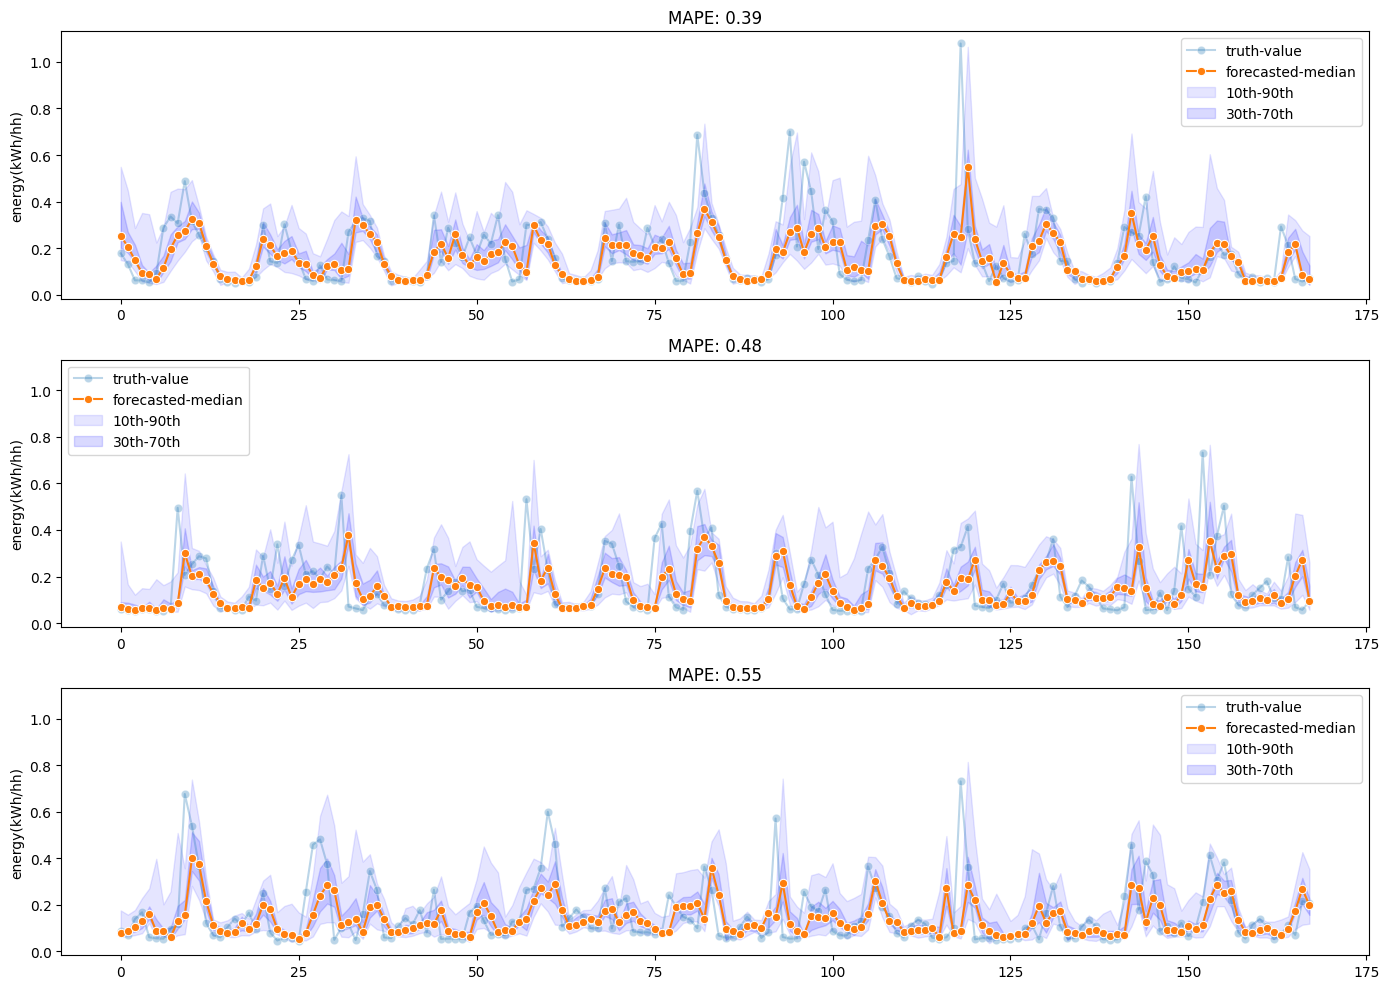

In [58]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

### Tuning Quantile-LightGBM

In [66]:
from lightgbm import LGBMRegressor
from sklearn.metrics import (
  mean_absolute_percentage_error, 
  mean_absolute_error, 
  mean_squared_error, 
  r2_score,
  mean_pinball_loss
)

class QuantileLightGBM:
  def __init__(self, alphas=[0.1, 0.3, 0.5, 0.7, 0.9], **keyword_args):
    self.models = {}
    self.alphas = alphas
    self.hyperparams = keyword_args

  def fit(self, X_train, y_train):
    # train respective models for each quantile
    for alpha in self.alphas:
      model = LGBMRegressor(
        random_state=42, 
        objective='quantile', 
        alpha=alpha,
        n_jobs=5, # use 5 CPU cores
        **self.hyperparams
      )
      
      # fit the model
      model.fit(X_train, y_train)
      self.models[f'model_{str(alpha)}'] = model # save the model

  def predict(self, X_test):
    y_pred = {}
    for i in range(len(self.alphas)):
      alpha = self.alphas[i]
      model = self.models[f'model_{str(alpha)}']
      y_pred[f'pred_{str(alpha)}'] = model.predict(X_test)

    return pd.DataFrame(y_pred)
  
  def evaluate(self, X_test, y_test):
      y_pred = self.predict(X_test)

      # point metrics
      mape = mean_absolute_percentage_error(y_test, y_pred['pred_0.5'])
      mae = mean_absolute_error(y_test, y_pred['pred_0.5'])
      mse = mean_squared_error(y_test, y_pred['pred_0.5'])
      rmse = mean_squared_error(y_test, y_pred['pred_0.5'], squared=False)
      r2 = r2_score(y_test, y_pred['pred_0.5'])
      adj_r2 = adjusted_r2(y_test, y_pred['pred_0.5'])

      # quantile loss
      loss_10 = mean_pinball_loss(y_test, y_pred['pred_0.1'], alpha=0.1)
      loss_30 = mean_pinball_loss(y_test, y_pred['pred_0.3'], alpha=0.3)
      loss_50 = mean_pinball_loss(y_test, y_pred['pred_0.5'], alpha=0.5)
      loss_70 = mean_pinball_loss(y_test, y_pred['pred_0.7'], alpha=0.7)
      loss_90 = mean_pinball_loss(y_test, y_pred['pred_0.9'], alpha=0.9)

      return {
        'mape': mape, 'mse': mse, 'rmse': rmse,
        'mae': mae, 'r2': r2, 'adjusted_r2': adj_r2,
        'pinball_loss_10': loss_10, 'pinball_loss_30': loss_30, 'pinball_loss_50': loss_50,
        'pinball_loss_70': loss_70, 'pinball_loss_90': loss_90
      }

In [72]:
from sklearn.model_selection import ParameterGrid, KFold

# reshape back to the original shape for LightGBM
ml_train = X_train.reshape(X_train.shape[0], X_train.shape[2]) 
ml_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

# combine both ml dataset to form a whole dataset, then the KFold will handle the splitting of training/testing
combined_X = np.vstack((ml_train, ml_test))
combined_y = pd.concat([y_train, y_test], axis=0).values # y_train, y_test is pandas object so using pd.concat()

param_grid = {
  'max_depth': [8, 9, 10],
  'n_estimators': [500, 750, 1000],
  'learning_rate': [0.01, 0.001, 0.03, 0.003],
  'reg_alpha': [0.5, 0.7]
}
param_grid = ParameterGrid(param_grid)
fold_generator = KFold(n_splits=3, shuffle=True, random_state=42)
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]

grid_results = { 'folds': [], 'params_used': [], 'pinball_loss_10': [], 'pinball_loss_30': [], 'pinball_loss_50': [], 'pinball_loss_70': [], 'pinball_loss_90': [], 'mape': [], 'mse': [], 'mae': [], 'rmse': [], 'r2': [], 'adjusted_r2': [] }

model_count = 0
for hyperparameters in param_grid:
  for i, (train_idx, test_idx) in enumerate(fold_generator.split(combined_X)):
    print(f"Training for model {model_count} on fold {i}... Hyperparameter: {hyperparameters}")
    lgbm_model = QuantileLightGBM(alphas=alphas, **hyperparameters) # uses 5 CPU cores
    lgbm_model.fit(combined_X[train_idx], combined_y[train_idx])
    metrics = lgbm_model.evaluate(combined_X[test_idx], combined_y[test_idx])

    # store the results
    grid_results['folds'].append(i)
    grid_results['params_used'].append(hyperparameters)
    grid_results['mape'].append(metrics['mape'])
    grid_results['mse'].append(metrics['mse'])
    grid_results['rmse'].append(metrics['rmse'])
    grid_results['mae'].append(metrics['mae'])
    grid_results['r2'].append(metrics['r2'])
    grid_results['adjusted_r2'].append(metrics['adjusted_r2'])
    grid_results['pinball_loss_10'].append(metrics['pinball_loss_10'])
    grid_results['pinball_loss_30'].append(metrics['pinball_loss_30'])
    grid_results['pinball_loss_50'].append(metrics['pinball_loss_50'])
    grid_results['pinball_loss_70'].append(metrics['pinball_loss_70'])
    grid_results['pinball_loss_90'].append(metrics['pinball_loss_90'])

  # for progress
  print(f"Training completed for Model {model_count}...")
  model_count += 1

grid_results = pd.DataFrame(grid_results)

Training for model 0 on fold 0... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.5}
Training for model 0 on fold 1... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.5}
Training for model 0 on fold 2... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.5}
Training completed for Model 0...
Training for model 1 on fold 0... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.7}
Training for model 1 on fold 1... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.7}
Training for model 1 on fold 2... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 0.7}
Training completed for Model 1...
Training for model 2 on fold 0... Hyperparameter: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 750, 'reg_alpha': 0.5}
Training for model 2 on fold 

In [74]:
grid_results.to_csv('grid_results_quantile_lightgbm.csv', index=False)

In [75]:
import json

grid_results['params_used_str'] = grid_results['params_used'].apply(lambda x: json.dumps(x))
grid_results['total_pinball_loss'] = grid_results['pinball_loss_10'] + grid_results['pinball_loss_30'] + grid_results['pinball_loss_50'] + grid_results['pinball_loss_70'] + grid_results['pinball_loss_90']
mean_results = grid_results.groupby(['params_used_str'])[['pinball_loss_10', 'pinball_loss_30',
       'pinball_loss_50', 'pinball_loss_70', 'pinball_loss_90', 'total_pinball_loss', 'mape', 'mse',
       'mae', 'rmse', 'r2', 'adjusted_r2']].mean().reset_index()

print("Best hyperparameter:")
mean_results.sort_values(by='total_pinball_loss', ascending=True)['params_used_str'].iloc[0]

Best hyperparameter:


'{"learning_rate": 0.03, "max_depth": 10, "n_estimators": 1000, "reg_alpha": 0.5}'

In [76]:
# top 10 hyperparams
mean_results.sort_values(by='total_pinball_loss', ascending=True).head(10)

params_used_str  pinball_loss_10  \
54  {"learning_rate": 0.03, "max_depth": 10, "n_es...         0.024901   
55  {"learning_rate": 0.03, "max_depth": 10, "n_es...         0.024937   
67  {"learning_rate": 0.03, "max_depth": 9, "n_est...         0.024910   
66  {"learning_rate": 0.03, "max_depth": 9, "n_est...         0.024936   
61  {"learning_rate": 0.03, "max_depth": 8, "n_est...         0.024913   
60  {"learning_rate": 0.03, "max_depth": 8, "n_est...         0.024966   
59  {"learning_rate": 0.03, "max_depth": 10, "n_es...         0.025029   
58  {"learning_rate": 0.03, "max_depth": 10, "n_es...         0.025022   
71  {"learning_rate": 0.03, "max_depth": 9, "n_est...         0.025028   
70  {"learning_rate": 0.03, "max_depth": 9, "n_est...         0.025020   

    pinball_loss_30  pinball_loss_50  pinball_loss_70  pinball_loss_90  \
54         0.057584         0.075806         0.077814         0.051445   
55         0.057599         0.075804         0.077830         0.051386   
67         0.057575         0.075932         0.077843         0.051429   
66         0.057587         0.075933         0.077790         0.051468   
61         0.057655         0.076014         0.077854         0.051524   
60         0.057663         0.076019         0.078054         0.051511   
59         0.057976         0.076445         0.078219         0.051763   
58         0.058000         0.076431         0.078254         0.051807   
71         0.058003         0.076496         0.078328         0.051791   
70         0.058063         0.076507         0.078356         0.051787   

    total_pinball_loss          mape       mse       mae      rmse        r2  \
54            0.287550  8.534439e+11  0.109739  0.151611  0.331269  0.649123   
55            0.287556  8.545429e+11  0.109604  0.151607  0.331064  0.649553   
67            0.287690  8.560962e+11  0.110261  0.151865  0.332056  0.647453   
66            0.287715  8.267166e+11  0.110036  0.151866  0.331717  0.648171   
61            0.287960  8.332574e+11  0.110069  0.152028  0.331765  0.648068   
60            0.288213  8.393267e+11  0.110045  0.152038  0.331730  0.648143   
59            0.289432  8.899323e+11  0.111522  0.152891  0.333947  0.643420   
58            0.289514  8.974646e+11  0.111635  0.152862  0.334117  0.643061   
71            0.289647  8.912709e+11  0.111714  0.152993  0.334235  0.642807   
70            0.289733  8.775358e+11  0.111680  0.153014  0.334184  0.642917   

    adjusted_r2  
54     0.649121  
55     0.649552  
67     0.647452  
66     0.648170  
61     0.648066  
60     0.648141  
59     0.643419  
58     0.643060  
71     0.642806  
70     0.642915

In [ ]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
hyperparameters = {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 1000, 'reg_alpha': 0.5}

lgbm_model = QuantileLightGBM(alphas=alphas, **hyperparameters)
lgbm_model.fit(ml_train, y_train)

metrics = lgbm_model.evaluate(ml_test, y_test)
metrics

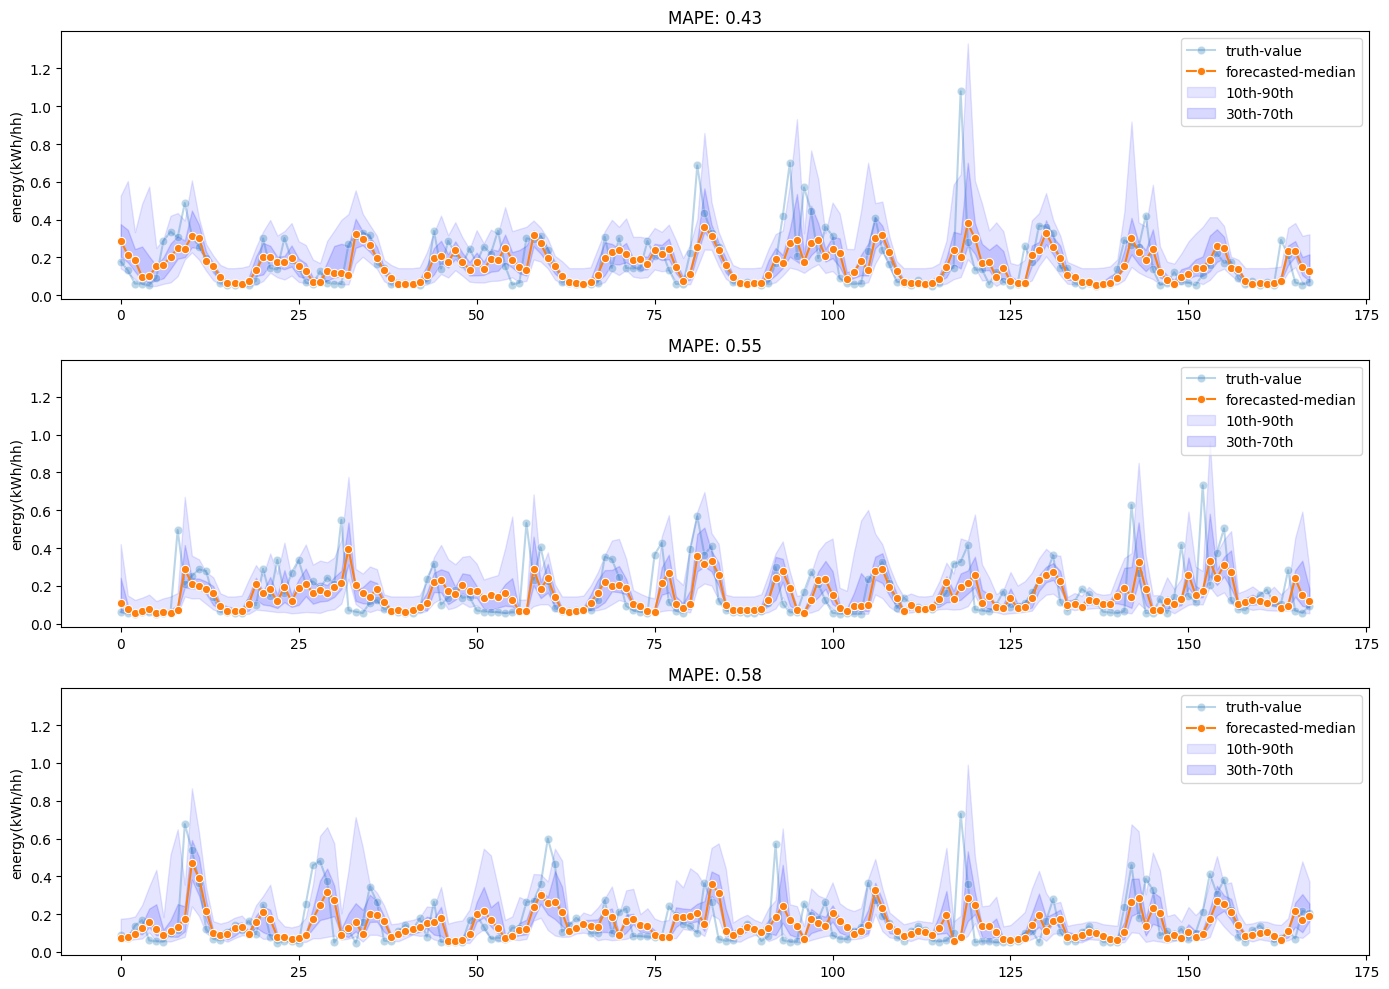

In [78]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

### Tuning Quantile-LSTM

1. Add 1 LSTM Layer
2. Add 2 LSTM Layer
3. Add 1 Dense Layer

In [23]:
from tensorflow.keras.layers import (
  Dense, LSTM, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Create Model
input_layer = Input(shape=(1, X_train.shape[2]))
layer = LSTM(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_10 = TimeDistributed(Dense(1), name="output_10")(layer)
output_layer_30 = TimeDistributed(Dense(1), name="output_30")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_70 = TimeDistributed(Dense(1), name="output_70")(layer)
output_layer_90 = TimeDistributed(Dense(1), name="output_90")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_10, output_layer_30, output_layer_50, output_layer_70, output_layer_90])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_10": lambda y, y_hat: pinball_loss(y, y_hat, 0.1),
    "output_30": lambda y, y_hat: pinball_loss(y, y_hat, 0.3),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_70": lambda y, y_hat: pinball_loss(y, y_hat, 0.7),
    "output_90": lambda y, y_hat: pinball_loss(y, y_hat, 0.9)
  }
)

history = model.fit(
  X_train,
  [y_train, y_train, y_train, y_train, y_train],
  epochs=50,
  validation_data=(X_test, [y_test, y_test, y_test, y_test, y_test]),
  batch_size=168,
  callbacks=[earlystop]
)

Epoch 1/50
4087/4087 [==============================] - 47s 11ms/step - loss: 0.8161 - output_10_loss: 0.0329 - output_30_loss: 0.0745 - output_50_loss: 0.0966 - output_70_loss: 0.0995 - output_90_loss: 0.0701 - val_loss: 0.4462 - val_output_10_loss: 0.0362 - val_output_30_loss: 0.0785 - val_output_50_loss: 0.0977 - val_output_70_loss: 0.0979 - val_output_90_loss: 0.0678
Epoch 2/50
4087/4087 [==============================] - 43s 10ms/step - loss: 0.4069 - output_10_loss: 0.0313 - output_30_loss: 0.0691 - output_50_loss: 0.0879 - output_70_loss: 0.0894 - output_90_loss: 0.0628 - val_loss: 0.4365 - val_output_10_loss: 0.0356 - val_output_30_loss: 0.0765 - val_output_50_loss: 0.0954 - val_output_70_loss: 0.0964 - val_output_90_loss: 0.0674
Epoch 3/50
4087/4087 [==============================] - 43s 11ms/step - loss: 0.4011 - output_10_loss: 0.0310 - output_30_loss: 0.0683 - output_50_loss: 0.0869 - output_70_loss: 0.0885 - output_90_loss: 0.0622 - val_loss: 0.4357 - val_output_10_loss: 0

In [24]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1, 134)]     0           []                               
                                                                                                  
 lstm_7 (LSTM)                  (None, 1, 100)       94000       ['input_5[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 1, 100)       0           ['lstm_7[0][0]']                 
                                                                                                  
 time_distributed_8 (TimeDistri  (None, 1, 168)      16968       ['dropout_4[0][0]']              
 buted)                                                                                     

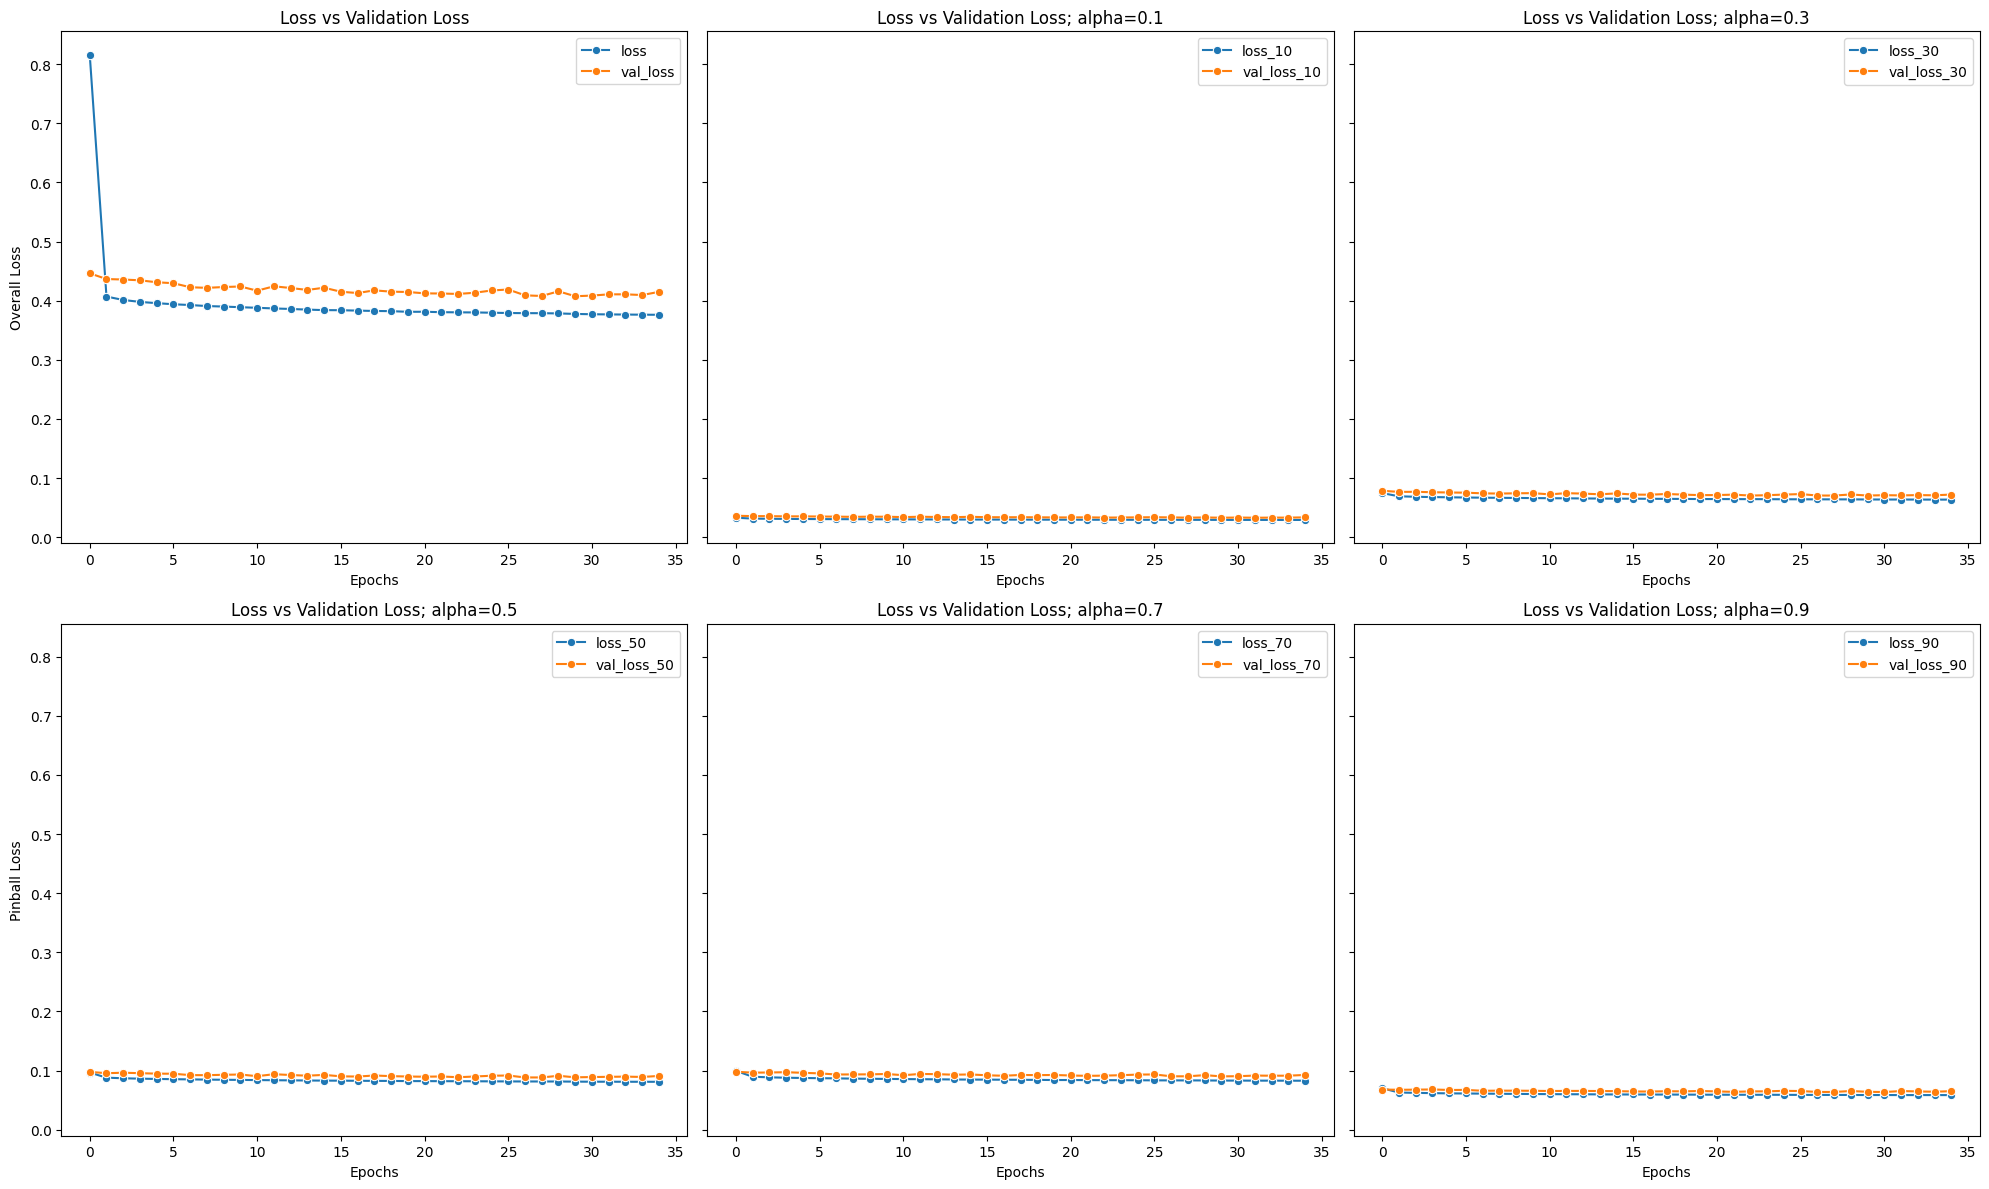

In [25]:
plot_training_metrics(history)

In [26]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.1': y_pred[0].ravel(),
  'pred_0.3': y_pred[1].ravel(),
  'pred_0.5': y_pred[2].ravel(),
  'pred_0.7': y_pred[3].ravel(),
  'pred_0.9': y_pred[4].ravel()
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 5s 2ms/step
RMSE: 0.3721505631329666
MSE: 0.13849604164018417
MAE: 0.1769131988950691
MAPE: 1809980130596.9688
R2 Score: 0.6661883254313428
Adjusted R2 Score: 0.666183951187445
Pinball loss with alpha 0.1: 0.03283577144042705
Pinball loss with alpha 0.3: 0.07033381988686473
Pinball loss with alpha 0.5: 0.08845659944753455
Pinball loss with alpha 0.7: 0.09008191892370432
Pinball loss with alpha 0.9: 0.06397409238422071


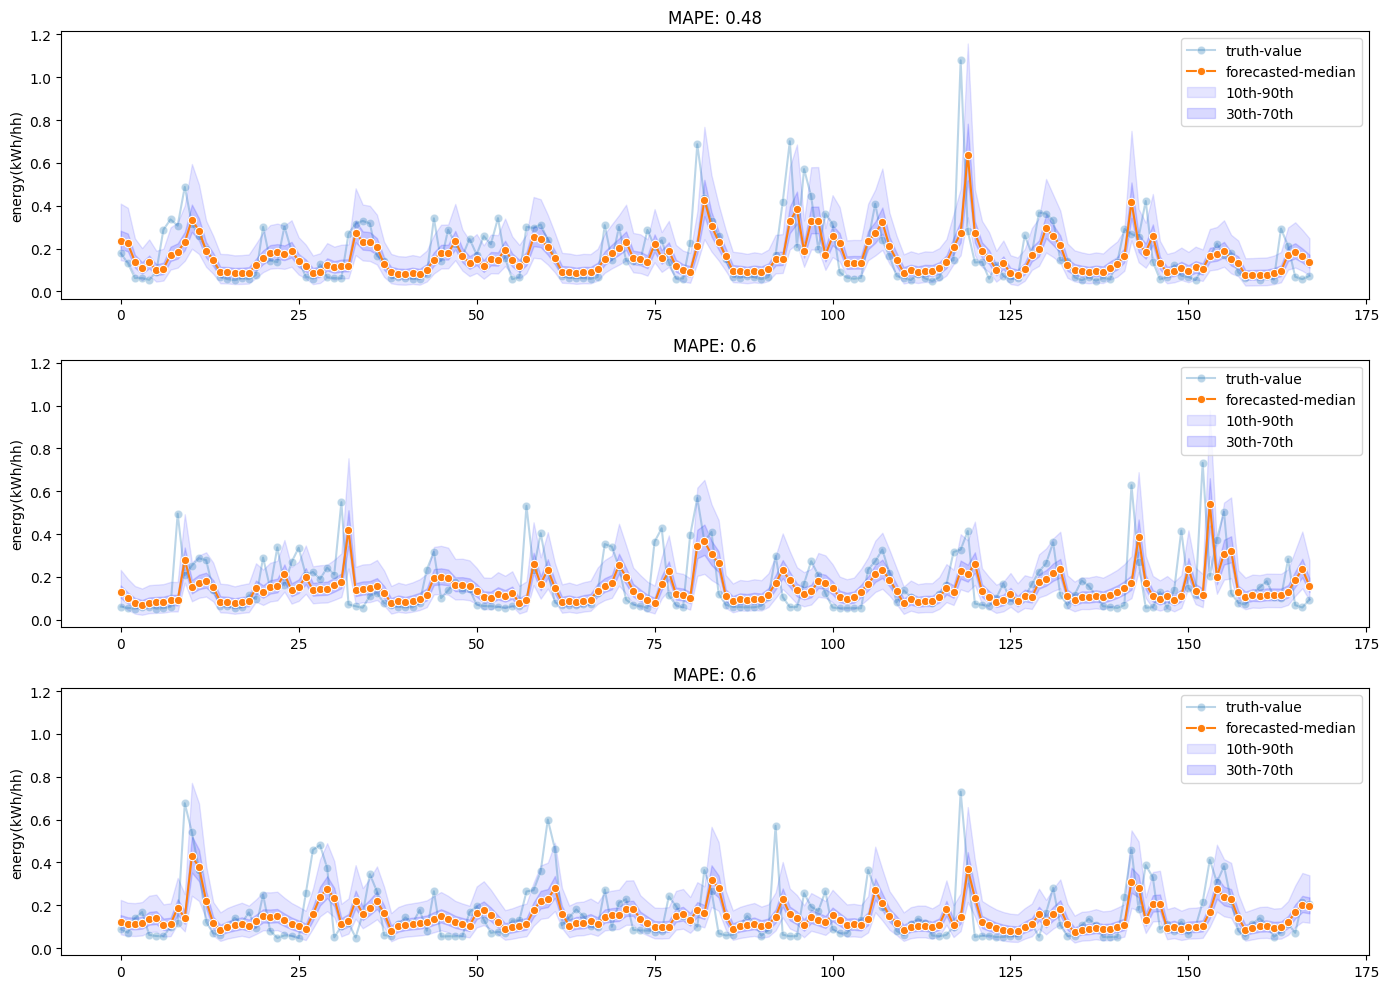

In [27]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, LSTM,
    TimeDistributed, Dropout, Input
)
import keras_tuner as kt

class LSTMTunedModel(kt.HyperModel):

    def build(self, hyperparameters):
        # for reproducibility
        tf.random.set_seed(42)
        tf.keras.utils.set_random_seed(42)
        tf.config.experimental.enable_op_determinism()

        hp_lstm_units = hyperparameters.Int("lstm_units", min_value=100, max_value=300, step=50)
        hp_dropout_rate = hyperparameters.Choice("dropout", values=[0.2, 0.3, 0.4, 0.5])
        hp_learning_rate = hyperparameters.Choice("learning_rate", values=[0.001, 0.0001, 0.00001, 0.003, 0.0003, 0.00003])

        # input and LSTM layers
        input_layer = Input(shape=(1, X_train.shape[2]))
        layer = LSTM(hp_lstm_units, return_sequences=True)(input_layer)
        layer = LSTM(hp_lstm_units, return_sequences=True)(layer)
        layer = LSTM(hp_lstm_units, return_sequences=True)(layer)
        layer = Dropout(hp_dropout_rate)(layer)

        # predictive layers
        layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
        layer = TimeDistributed(Dense(64, activation='relu'))(layer)

        # output layers
        output_layer_10 = TimeDistributed(Dense(1), name="output_10")(layer)
        output_layer_30 = TimeDistributed(Dense(1), name="output_30")(layer)
        output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
        output_layer_70 = TimeDistributed(Dense(1), name="output_70")(layer)
        output_layer_90 = TimeDistributed(Dense(1), name="output_90")(layer)
        model = Model(inputs=[input_layer], outputs=[output_layer_10, output_layer_30, output_layer_50, output_layer_70, output_layer_90])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss={
                "output_10": lambda y, y_hat: pinball_loss(y, y_hat, 0.1),
                "output_30": lambda y, y_hat: pinball_loss(y, y_hat, 0.3),
                "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
                "output_70": lambda y, y_hat: pinball_loss(y, y_hat, 0.7),
                "output_90": lambda y, y_hat: pinball_loss(y, y_hat, 0.9)
            }
        )

        return model

    def fit(self, hyperparameters, model, *args, **kwargs):
        # for reproducibility
        tf.random.set_seed(42)
        tf.keras.utils.set_random_seed(42)
        tf.config.experimental.enable_op_determinism()
        
        return model.fit(
            *args,
            batch_size=hyperparameters.Choice("batch_size", [168, 336, 504]),
            **kwargs,
        )

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner = kt.Hyperband(
  LSTMTunedModel(),
  objective='val_loss',
  seed=42,
  max_epochs=50,
  factor=3,
  directory='quantile_lstm_tuned', # path to save the model tuning data
  project_name="tune_quantile_lstm",
  overwrite=False
)
tuner.search(X_train, [y_train, y_train, y_train, y_train, y_train], epochs=50, validation_data=(X_test, [y_test, y_test, y_test, y_test, y_test]), callbacks=[earlystop])

Trial 90 Complete [00h 21m 49s]
val_loss: 0.34786155819892883

Best val_loss So Far: 0.33748868107795715
Total elapsed time: 07h 27m 40s


In [29]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'lstm_units': 100,
 'dropout': 0.4,
 'learning_rate': 0.0003,
 'batch_size': 336,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# input 
input_layer = Input(shape=(1, X_train.shape[2]))

# stacked lstm
layer = LSTM(100, return_sequences=True)(input_layer)
layer = LSTM(100, return_sequences=True)(layer)
layer = LSTM(100, return_sequences=True)(layer)
layer = Dropout(0.4)(layer)

# full connected layer
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)

# output
output_layer_10 = TimeDistributed(Dense(1), name="output_10")(layer)
output_layer_30 = TimeDistributed(Dense(1), name="output_30")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_70 = TimeDistributed(Dense(1), name="output_70")(layer)
output_layer_90 = TimeDistributed(Dense(1), name="output_90")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_10, output_layer_30, output_layer_50, output_layer_70, output_layer_90])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss={
        "output_10": lambda y, y_hat: pinball_loss(y, y_hat, 0.1),
        "output_30": lambda y, y_hat: pinball_loss(y, y_hat, 0.3),
        "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
        "output_70": lambda y, y_hat: pinball_loss(y, y_hat, 0.7),
        "output_90": lambda y, y_hat: pinball_loss(y, y_hat, 0.9)
    }
)

history = model.fit(
    X_train, 
    [y_train, y_train, y_train, y_train, y_train], 
    epochs=50, 
    validation_data=(X_test, [y_test, y_test, y_test, y_test, y_test]), 
    batch_size=336,
    callbacks=[earlystop]
)

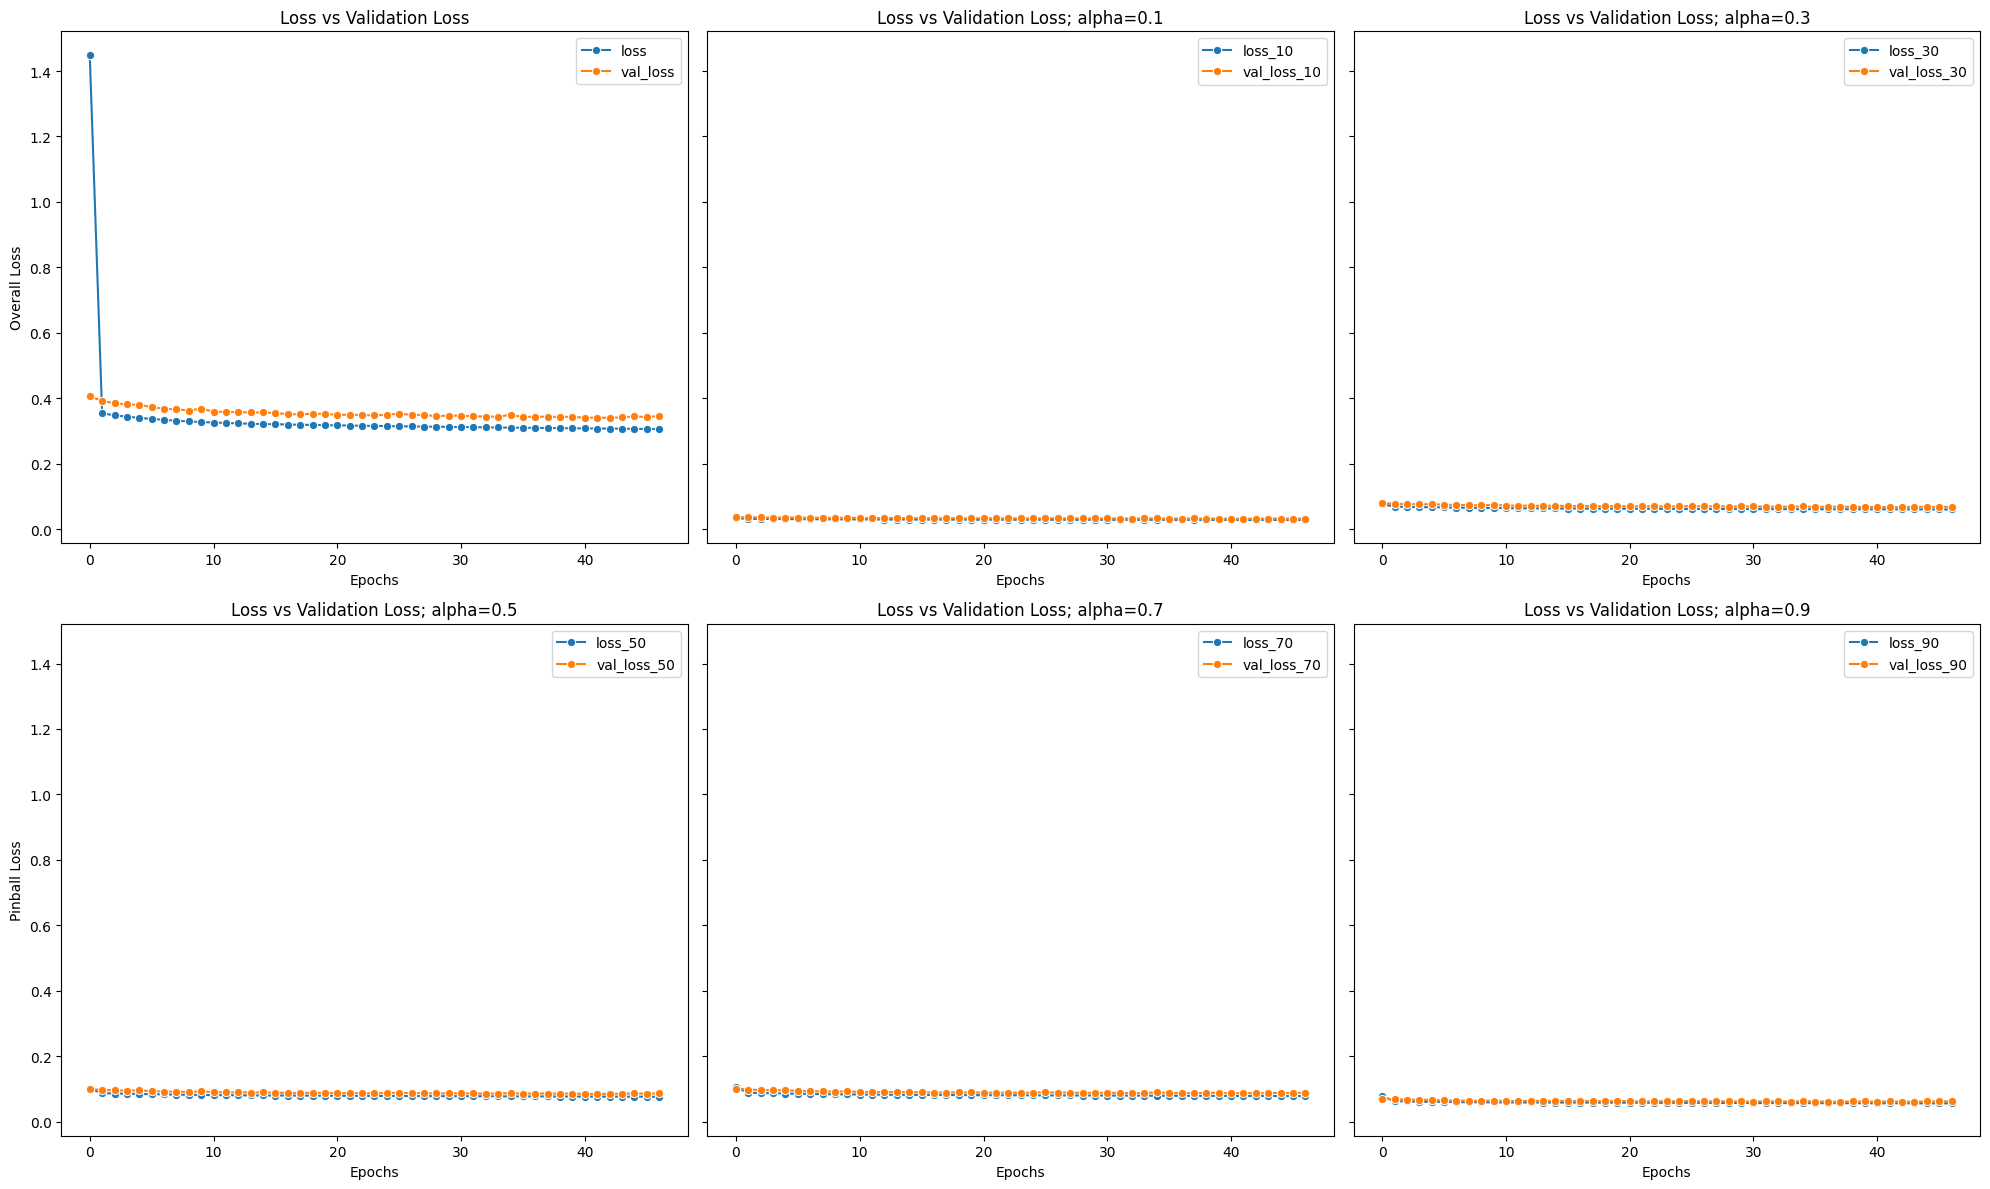

In [32]:
plot_training_metrics(history)

In [33]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.1': y_pred[0].ravel(),
  'pred_0.3': y_pred[1].ravel(),
  'pred_0.5': y_pred[2].ravel(),
  'pred_0.7': y_pred[3].ravel(),
  'pred_0.9': y_pred[4].ravel()
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 8s 3ms/step
RMSE: 0.3404738404151852
MSE: 0.11592243600706498
MAE: 0.16863916652711033
MAPE: 1477045144631.403
R2 Score: 0.7205966175977063
Adjusted R2 Score: 0.7205929563161108
Pinball loss with alpha 0.1: 0.03159784353878006
Pinball loss with alpha 0.3: 0.0666993422673228
Pinball loss with alpha 0.5: 0.08431958326355517
Pinball loss with alpha 0.7: 0.08692394124697891
Pinball loss with alpha 0.9: 0.06176414355839515


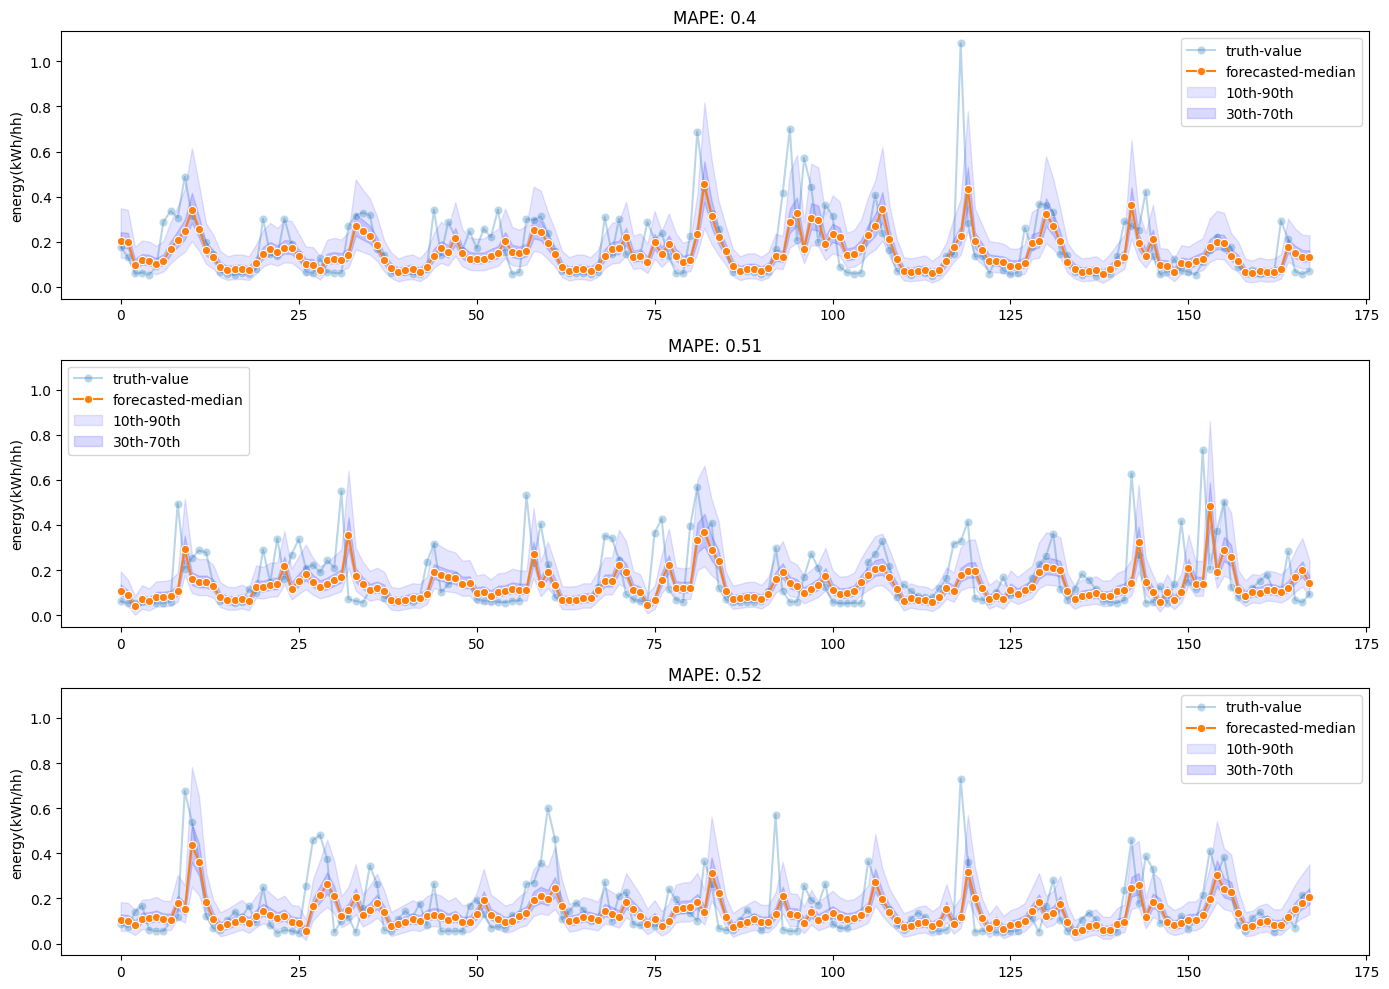

In [34]:
plot_forecast(y_pred, y_test, 3, 168, skip=(168*24))

### Hyperparameter Tuning for Quantile-GRU

1. Add 1 GRU Layer
2. Add 2 GRU Layer
3. Add 1 Dense Layer

In [53]:
from tensorflow.keras.layers import (
  Dense, GRU, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Create Model
input_layer = Input(shape=(1, X_train.shape[2]))
layer = GRU(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)

# output
output_layer_10 = TimeDistributed(Dense(1), name="output_10")(layer)
output_layer_30 = TimeDistributed(Dense(1), name="output_30")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_70 = TimeDistributed(Dense(1), name="output_70")(layer)
output_layer_90 = TimeDistributed(Dense(1), name="output_90")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_10, output_layer_30, output_layer_50, output_layer_70, output_layer_90])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "output_10": lambda y, y_hat: pinball_loss(y, y_hat, 0.1),
        "output_30": lambda y, y_hat: pinball_loss(y, y_hat, 0.3),
        "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
        "output_70": lambda y, y_hat: pinball_loss(y, y_hat, 0.7),
        "output_90": lambda y, y_hat: pinball_loss(y, y_hat, 0.9)
    }
)

history = model.fit(
  X_train,
  [y_train, y_train, y_train, y_train, y_train],
  epochs=50,
  validation_data=(X_test, [y_test, y_test, y_test, y_test, y_test]),
  batch_size=168,
  callbacks=[earlystop]
)

Epoch 1/50
4087/4087 [==============================] - 50s 12ms/step - loss: 0.8190 - output_10_loss: 0.0329 - output_30_loss: 0.0744 - output_50_loss: 0.0963 - output_70_loss: 0.0989 - output_90_loss: 0.0695 - val_loss: 0.4435 - val_output_10_loss: 0.0361 - val_output_30_loss: 0.0779 - val_output_50_loss: 0.0968 - val_output_70_loss: 0.0971 - val_output_90_loss: 0.0674
Epoch 2/50
4087/4087 [==============================] - 45s 11ms/step - loss: 0.4058 - output_10_loss: 0.0314 - output_30_loss: 0.0690 - output_50_loss: 0.0877 - output_70_loss: 0.0891 - output_90_loss: 0.0626 - val_loss: 0.4341 - val_output_10_loss: 0.0356 - val_output_30_loss: 0.0764 - val_output_50_loss: 0.0949 - val_output_70_loss: 0.0956 - val_output_90_loss: 0.0669
Epoch 3/50
4087/4087 [==============================] - 44s 11ms/step - loss: 0.4002 - output_10_loss: 0.0311 - output_30_loss: 0.0682 - output_50_loss: 0.0867 - output_70_loss: 0.0882 - output_90_loss: 0.0622 - val_loss: 0.4337 - val_output_10_loss: 0

In [54]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1, 134)]     0           []                               
                                                                                                  
 gru_6 (GRU)                    (None, 1, 100)       70800       ['input_11[0][0]']               
                                                                                                  
 dropout_10 (Dropout)           (None, 1, 100)       0           ['gru_6[0][0]']                  
                                                                                                  
 time_distributed_21 (TimeDistr  (None, 1, 168)      16968       ['dropout_10[0][0]']             
 ibuted)                                                                                   

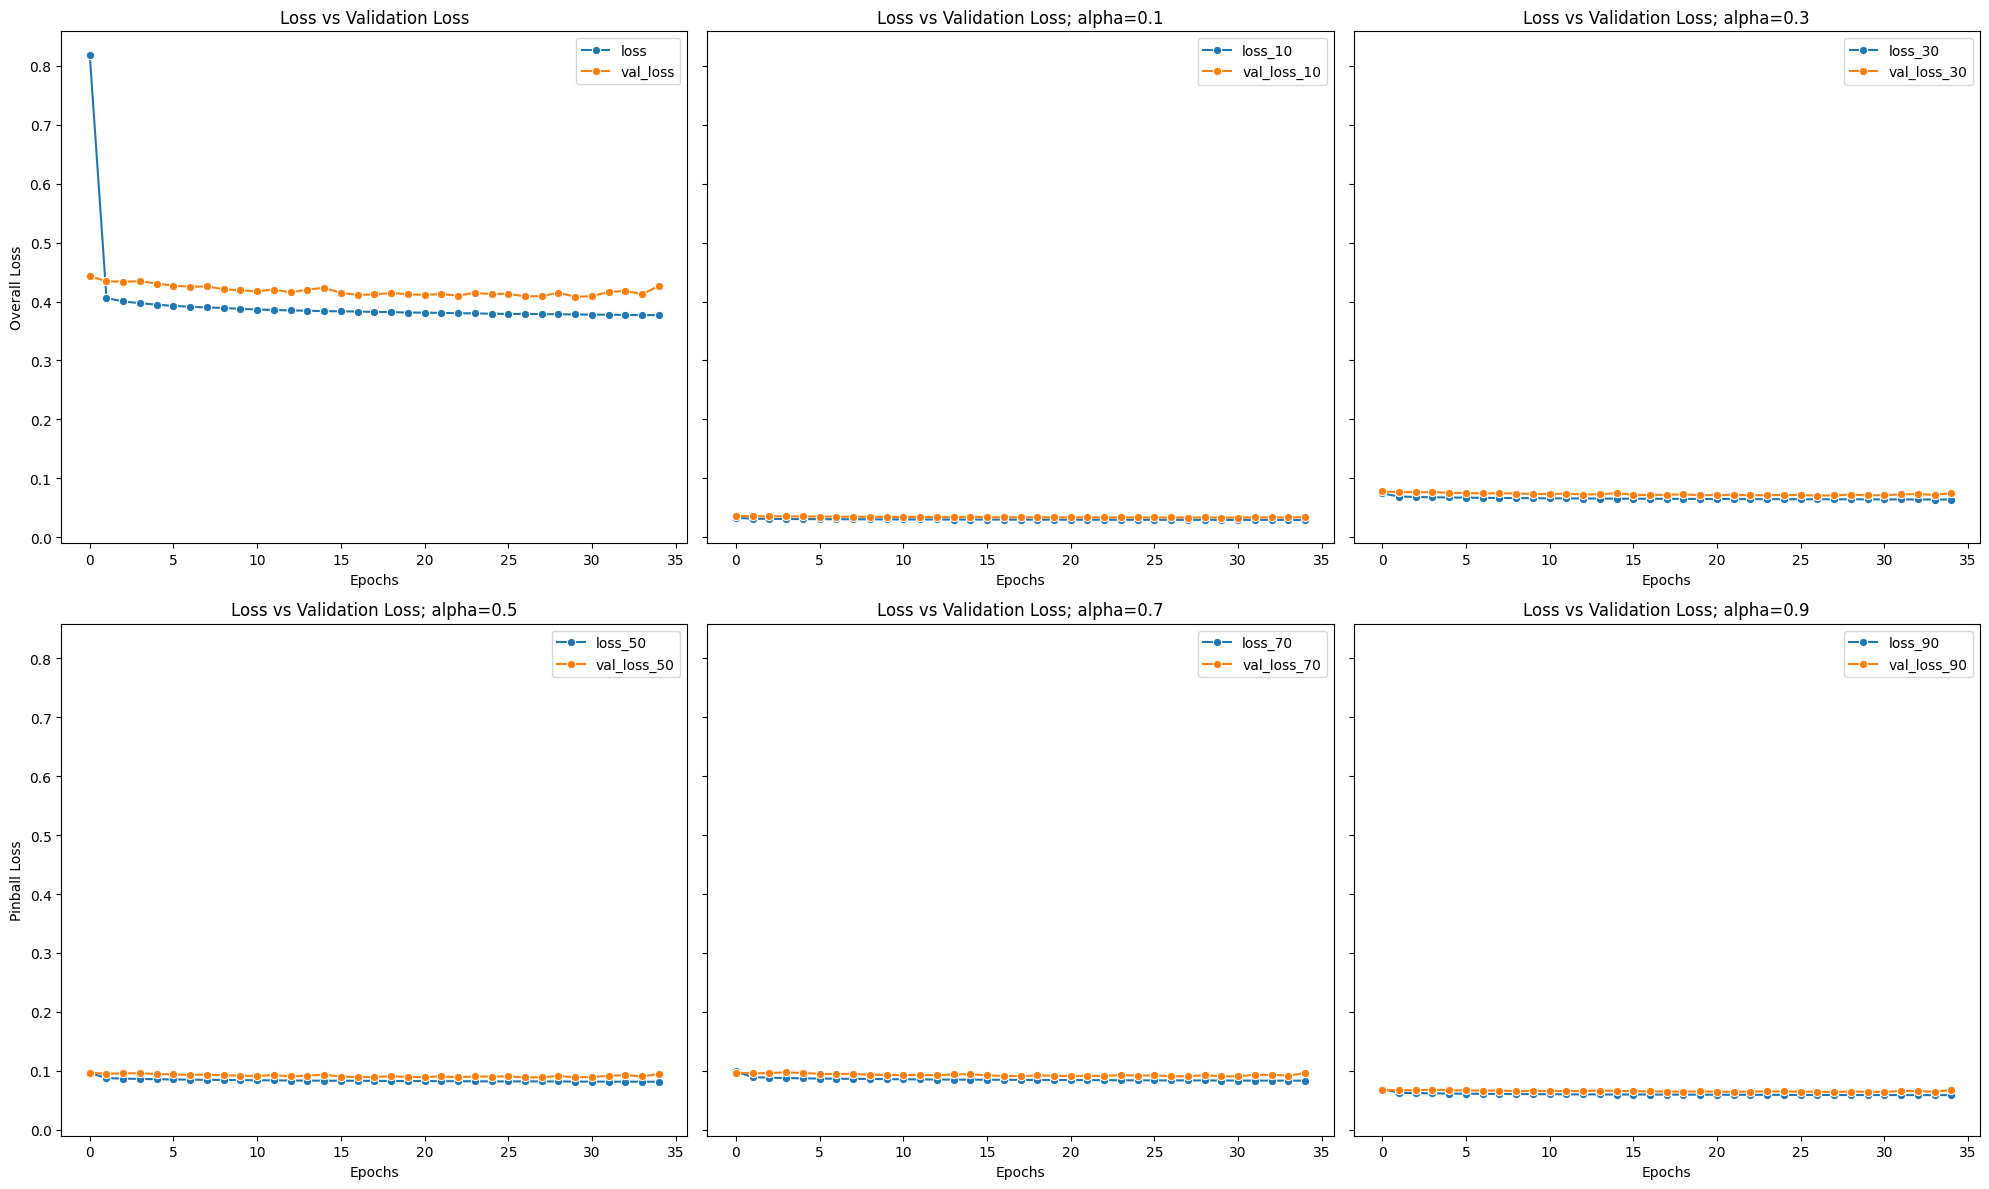

In [55]:
plot_training_metrics(history)

In [56]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.1': y_pred[0].ravel(),
  'pred_0.3': y_pred[1].ravel(),
  'pred_0.5': y_pred[2].ravel(),
  'pred_0.7': y_pred[3].ravel(),
  'pred_0.9': y_pred[4].ravel(),
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 6s 2ms/step
RMSE: 0.37539942087931033
MSE: 0.14092472519652158
MAE: 0.17806432367255842
MAPE: 1828681039792.852
R2 Score: 0.6603345630036437
Adjusted R2 Score: 0.6603301120524689
Pinball loss with alpha 0.1: 0.03315148928898549
Pinball loss with alpha 0.3: 0.07096063961275094
Pinball loss with alpha 0.5: 0.08903216183627921
Pinball loss with alpha 0.7: 0.09065355101936144
Pinball loss with alpha 0.9: 0.0641768077912072


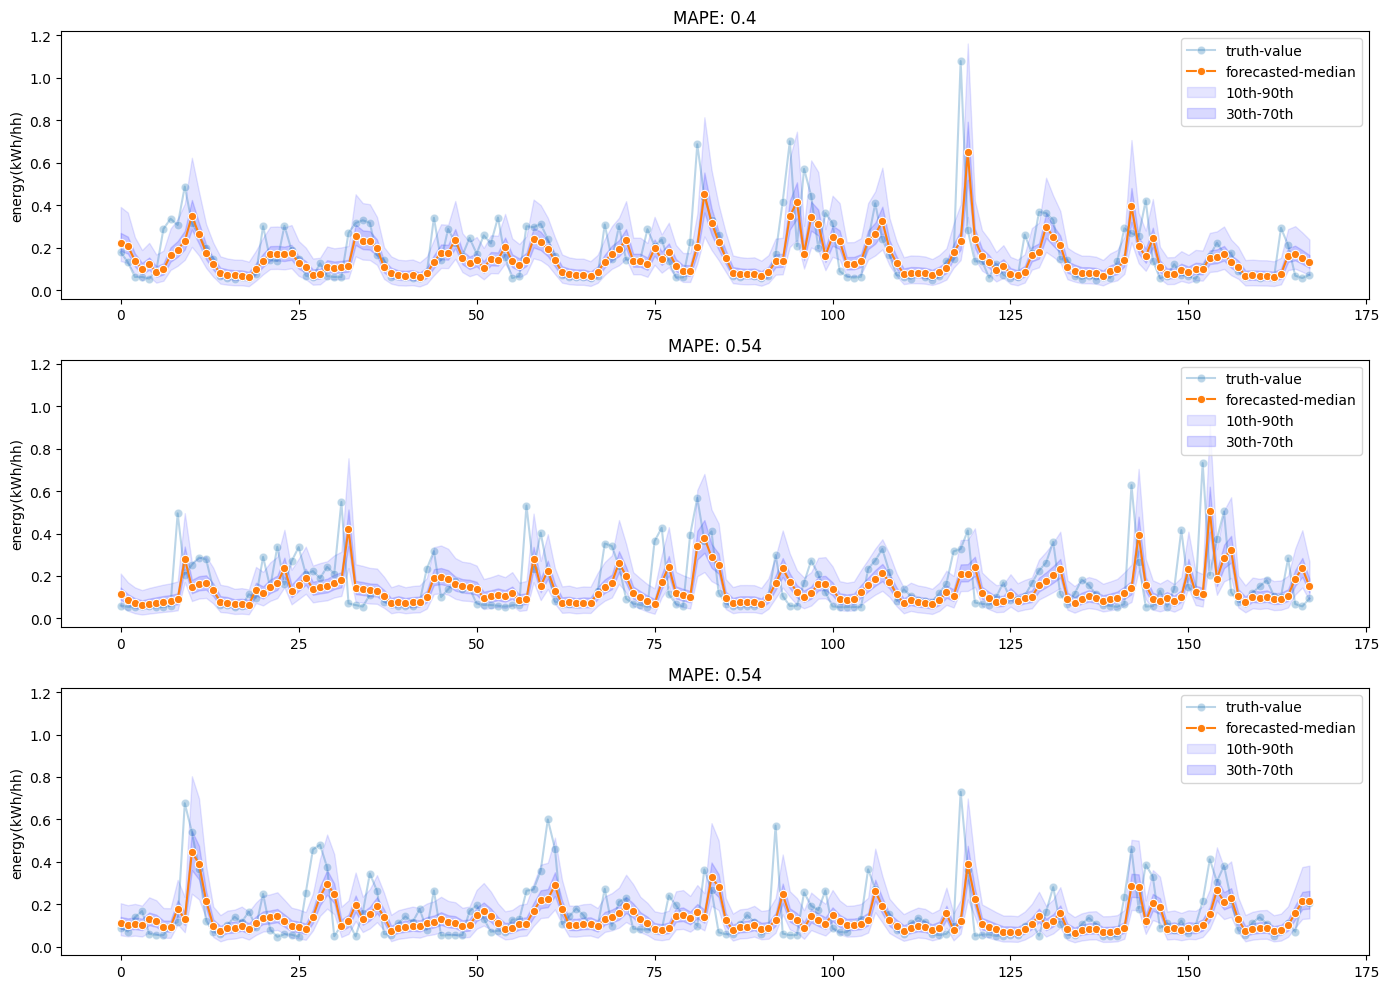

In [57]:
plot_forecast(y_pred, y_test, 3, 168, (24 * 168))

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, GRU, TimeDistributed, Dropout, Input
)
import keras_tuner as kt

class GRUTunedModel(kt.HyperModel):

    def build(self, hyperparameters):
        # for reproducibility
        tf.random.set_seed(42)
        tf.keras.utils.set_random_seed(42)
        tf.config.experimental.enable_op_determinism()

        hp_lstm_units = hyperparameters.Int("lstm_units", min_value=100, max_value=300, step=50)
        hp_dropout_rate = hyperparameters.Choice("dropout", values=[0.2, 0.3, 0.4, 0.5])
        hp_learning_rate = hyperparameters.Choice("learning_rate", values=[0.001, 0.0001, 0.00001, 0.003, 0.0003, 0.00003])

        # input 
        input_layer = Input(shape=(1, X_train.shape[2]))

        # stacked gru
        layer = GRU(hp_lstm_units, return_sequences=True)(input_layer)
        layer = GRU(hp_lstm_units, return_sequences=True)(layer)
        layer = GRU(hp_lstm_units, return_sequences=True)(layer)
        layer = Dropout(hp_dropout_rate)(layer)

        # full connected layer
        layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
        layer = TimeDistributed(Dense(64, activation='relu'))(layer)

        # output
        output_layer_10 = TimeDistributed(Dense(1), name="output_10")(layer)
        output_layer_30 = TimeDistributed(Dense(1), name="output_30")(layer)
        output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
        output_layer_70 = TimeDistributed(Dense(1), name="output_70")(layer)
        output_layer_90 = TimeDistributed(Dense(1), name="output_90")(layer)
        model = Model(inputs=[input_layer], outputs=[output_layer_10, output_layer_30, output_layer_50, output_layer_70, output_layer_90])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss={
                "output_10": lambda y, y_hat: pinball_loss(y, y_hat, 0.1),
                "output_30": lambda y, y_hat: pinball_loss(y, y_hat, 0.3),
                "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
                "output_70": lambda y, y_hat: pinball_loss(y, y_hat, 0.7),
                "output_90": lambda y, y_hat: pinball_loss(y, y_hat, 0.9)
            }
        )

        return model

    def fit(self, hyperparameters, model, *args, **kwargs):
        # for reproducibility
        tf.random.set_seed(42)
        tf.keras.utils.set_random_seed(42)
        tf.config.experimental.enable_op_determinism()
        
        return model.fit(
            *args,
            batch_size=hyperparameters.Choice("batch_size", [168, 336, 504]),
            **kwargs,
        )

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner = kt.Hyperband(
  GRUTunedModel(),
  objective='val_loss',
  seed=42,
  max_epochs=50,
  factor=3,
  directory='quantile_gru_tuned', # path to save the model tuning data
  project_name="tune_quantile_gru",
  overwrite=False
)
tuner.search(X_train, [y_train, y_train, y_train, y_train, y_train], epochs=50, validation_data=(X_test, [y_test, y_test, y_test, y_test, y_test]), callbacks=[earlystop])

Trial 90 Complete [00h 23m 37s]
val_loss: 0.3384995460510254

Best val_loss So Far: 0.32412493228912354
Total elapsed time: 08h 00m 50s


In [59]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'lstm_units': 200,
 'dropout': 0.3,
 'learning_rate': 0.0003,
 'batch_size': 336,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0049'}

In [62]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# input 
input_layer = Input(shape=(1, X_train.shape[2]))

# stacked lstm
layer = GRU(200, return_sequences=True)(input_layer)
layer = GRU(200, return_sequences=True)(layer)
layer = GRU(200, return_sequences=True)(layer)
layer = Dropout(0.3)(layer)

# full connected layer
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)

# output
output_layer_10 = TimeDistributed(Dense(1), name="output_10")(layer)
output_layer_30 = TimeDistributed(Dense(1), name="output_30")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_70 = TimeDistributed(Dense(1), name="output_70")(layer)
output_layer_90 = TimeDistributed(Dense(1), name="output_90")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_10, output_layer_30, output_layer_50, output_layer_70, output_layer_90])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss={
        "output_10": lambda y, y_hat: pinball_loss(y, y_hat, 0.1),
        "output_30": lambda y, y_hat: pinball_loss(y, y_hat, 0.3),
        "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
        "output_70": lambda y, y_hat: pinball_loss(y, y_hat, 0.7),
        "output_90": lambda y, y_hat: pinball_loss(y, y_hat, 0.9)
    }
)

history = model.fit(
    X_train,
    [y_train, y_train, y_train, y_train, y_train],
    epochs=50,
    validation_data=(X_test, [y_test, y_test, y_test, y_test, y_test]),
    batch_size=336,
    callbacks=[earlystop]
)

Epoch 1/50
2044/2044 [==============================] - 32s 14ms/step - loss: 1.9028 - output_10_loss: 0.0328 - output_30_loss: 0.0741 - output_50_loss: 0.0957 - output_70_loss: 0.0990 - output_90_loss: 0.0697 - val_loss: 0.4075 - val_output_10_loss: 0.0364 - val_output_30_loss: 0.0785 - val_output_50_loss: 0.0977 - val_output_70_loss: 0.0993 - val_output_90_loss: 0.0689
Epoch 2/50
2044/2044 [==============================] - 28s 14ms/step - loss: 0.3590 - output_10_loss: 0.0312 - output_30_loss: 0.0684 - output_50_loss: 0.0864 - output_70_loss: 0.0878 - output_90_loss: 0.0620 - val_loss: 0.3977 - val_output_10_loss: 0.0360 - val_output_30_loss: 0.0777 - val_output_50_loss: 0.0968 - val_output_70_loss: 0.0978 - val_output_90_loss: 0.0681
Epoch 3/50
2044/2044 [==============================] - 27s 13ms/step - loss: 0.3528 - output_10_loss: 0.0309 - output_30_loss: 0.0675 - output_50_loss: 0.0854 - output_70_loss: 0.0868 - output_90_loss: 0.0615 - val_loss: 0.3960 - val_output_10_loss: 0

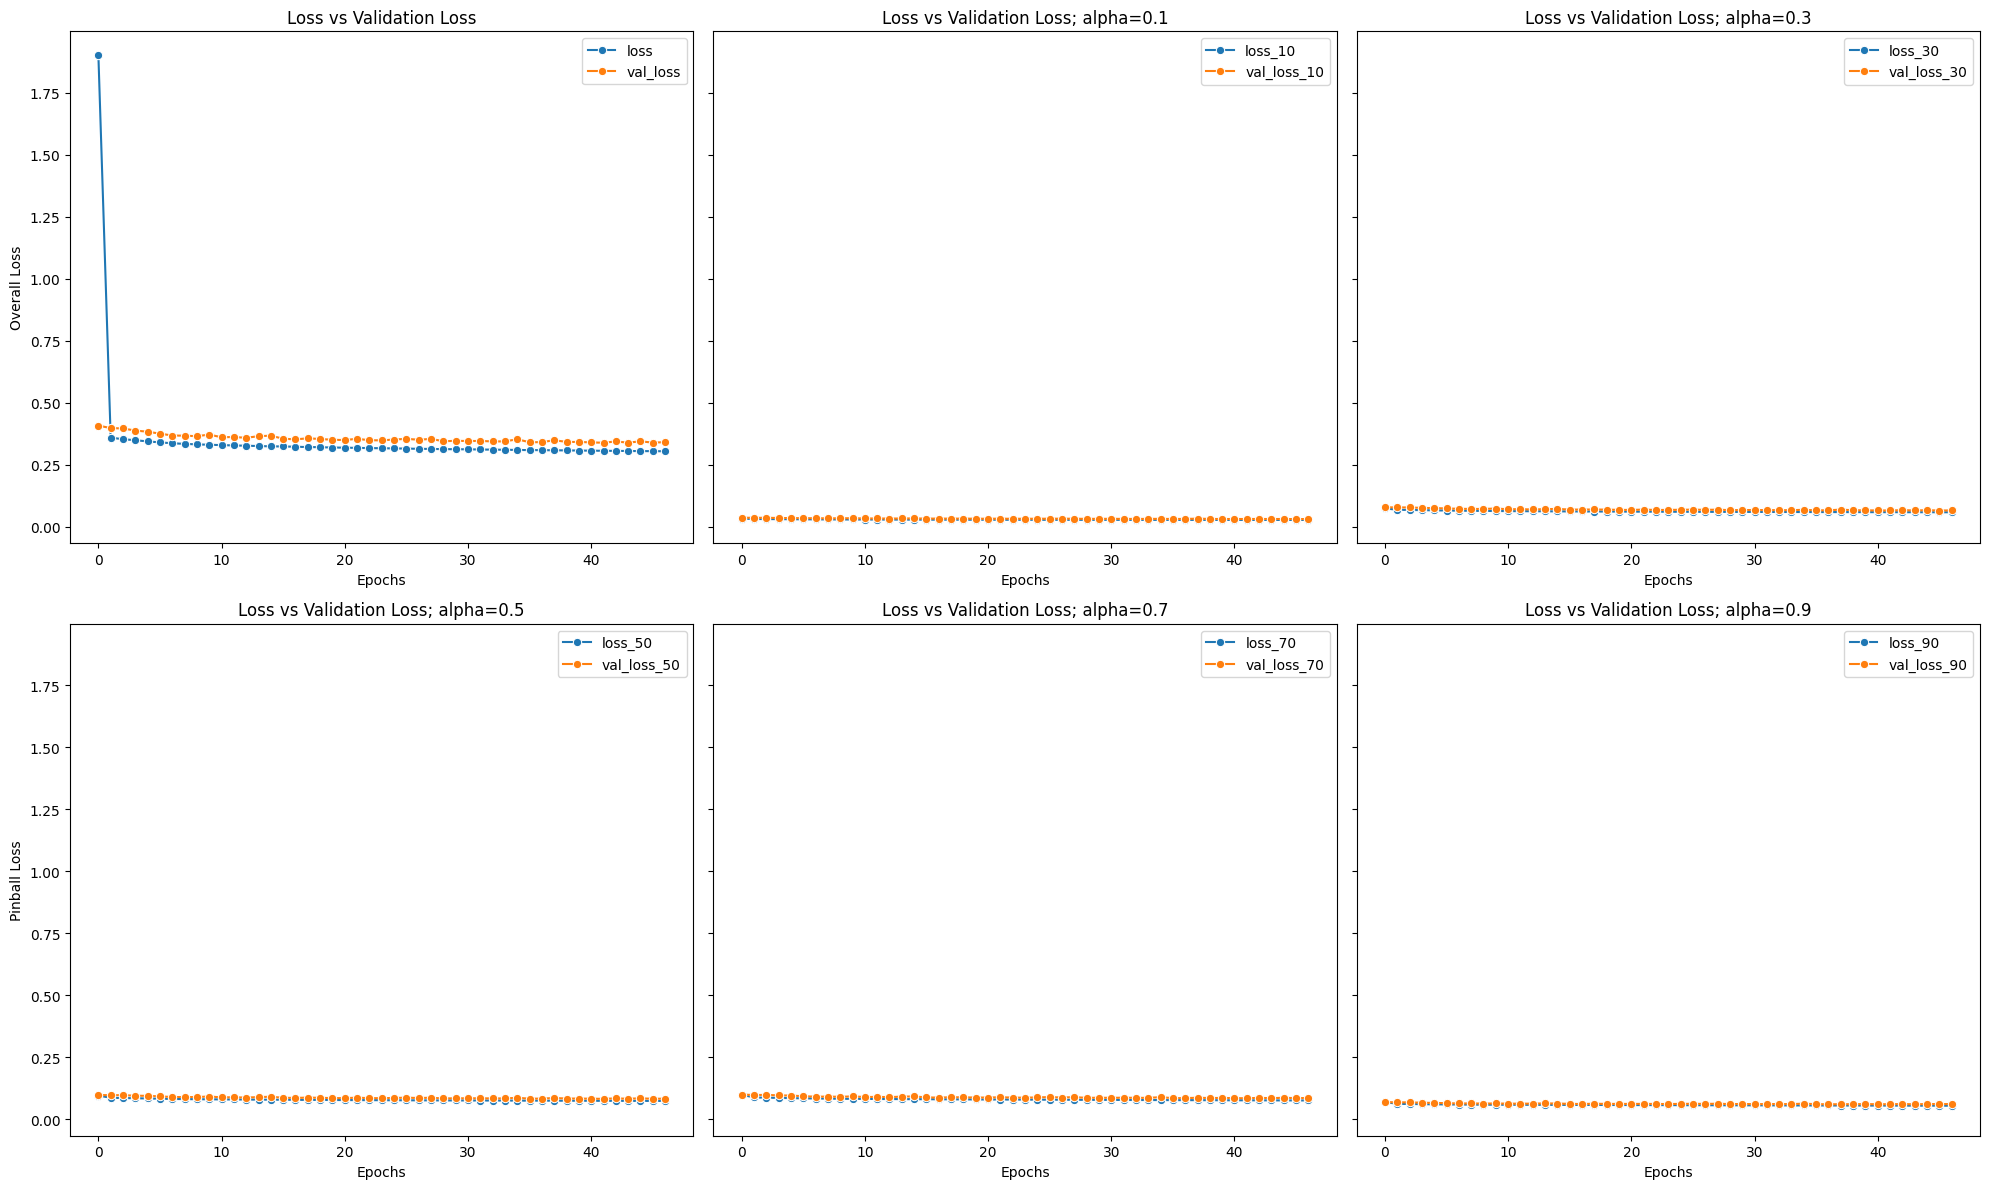

In [63]:
plot_training_metrics(history)

In [64]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).squeeze() # compress to 2-Dimensional array
y_pred = pd.DataFrame({
  'pred_0.1': y_pred[0].ravel(),
  'pred_0.3': y_pred[1].ravel(),
  'pred_0.5': y_pred[2].ravel(),
  'pred_0.7': y_pred[3].ravel(),
  'pred_0.9': y_pred[4].ravel(),
})

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 7s 3ms/step
RMSE: 0.3343860783370965
MSE: 0.11181404938566282
MAE: 0.1642868714159749
MAPE: 1558767852807.06
R2 Score: 0.7304989036242537
Adjusted R2 Score: 0.7304953721014938
Pinball loss with alpha 0.1: 0.031207774247235448
Pinball loss with alpha 0.3: 0.06552415962687591
Pinball loss with alpha 0.5: 0.08214343570798745
Pinball loss with alpha 0.7: 0.08444872284027692
Pinball loss with alpha 0.9: 0.06046458788793394


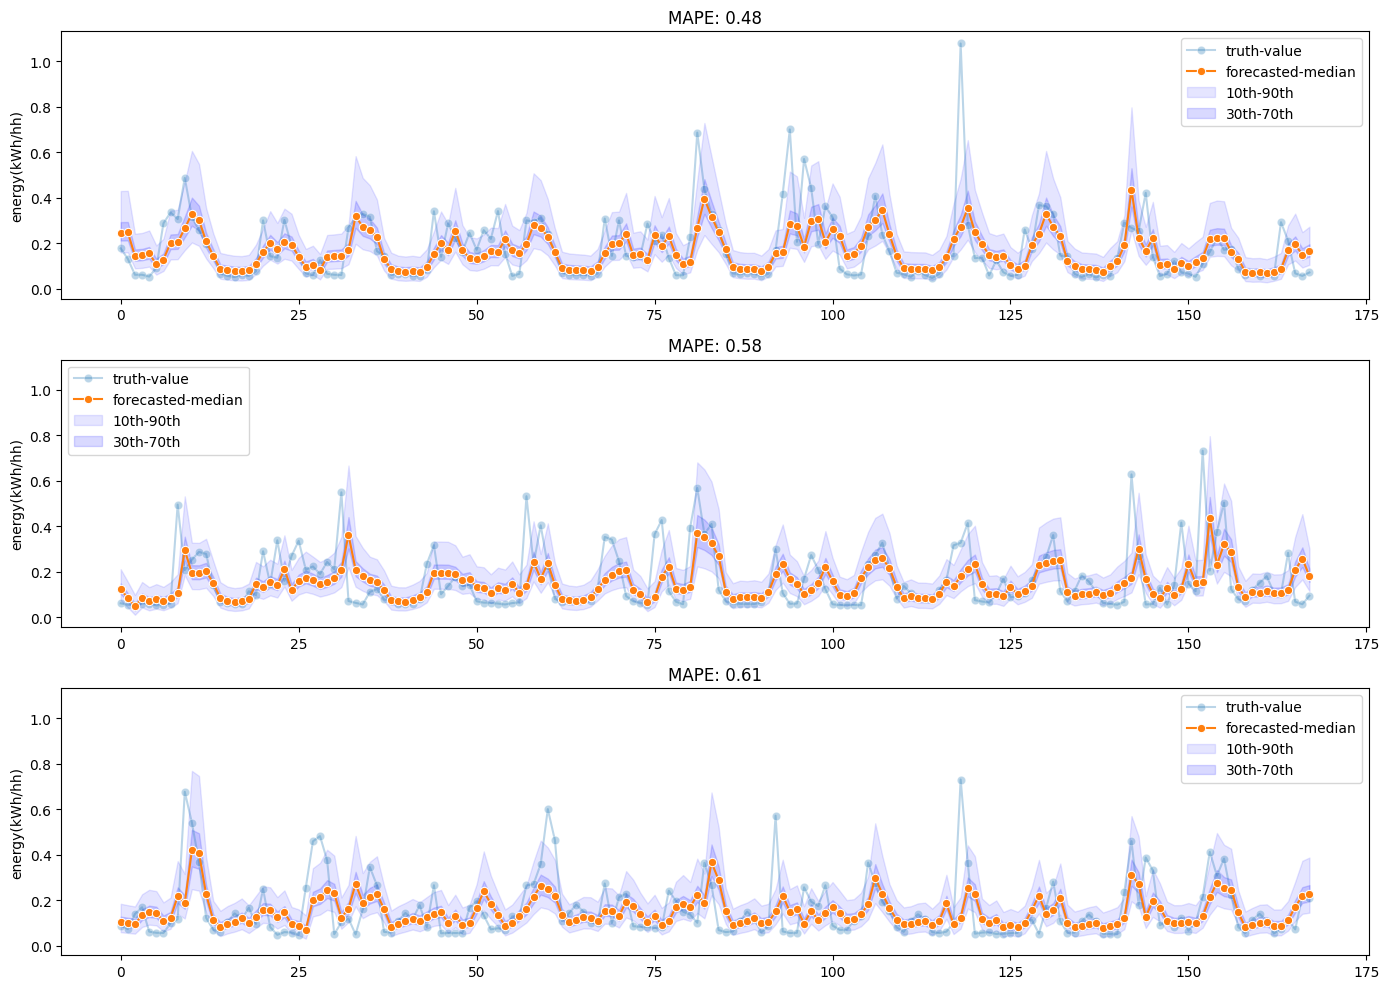

In [65]:
plot_forecast(y_pred, y_test, 3, 168, skip=(168*24))